In [155]:
import numpy as np 
import pandas as pd
import time
import random
from sklearn import metrics 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
custom_cmp = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',\
                '#7f7f7f', '#bcbd22', '#17becf', '#FB9E9D', '#FDBF6F', '#B2DF8A', '#CAAAC7', '#10C19B'])
matplotlib.rcParams.update({'font.size': 8.5})
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [199]:
class KMeans:
    max_iterations = None
    cent_init_method = None
    initial_cents = []
    centroids = []
    clusters = []

    def __init__(self, n_clusters, max_iterations = 100, cent_init_method=None):
        self.k = n_clusters
        self.data = None
        self.max_iterations = max_iterations
        self.cent_init_method = cent_init_method
        self.initial_cents = []
        self.centroids = []
        self.labels = []
        
    def initialise_centroids(self):
        if(self.cent_init_method == 'random'): 
            rand_points = np.random.permutation(self.data.shape[0])[:self.k]
            # rand_points = np.random.randint(self.data.shape[0], size=self.k)
            self.initial_cents = self.data[rand_points]
        elif(self.cent_init_method == 'kfirst'):
            self.initial_cents = self.data[:self.k]
        else:
            raise Exception("Unknown initialization method")
        return self.initial_cents
    
    def fit(self, data):
        start_time = time.time()
        self.data = data
        m = np.shape(self.data)[0]
        cluster_assignments = np.mat(np.zeros((m,2)))
        
        cents = self.initialise_centroids()
        self.initial_cents = cents.copy()
        self.centroids = cents.copy()

        iter_count = 0 
        not_converged = True
        while(iter_count < self.max_iterations and not_converged):
            dist_matrix = np.zeros((len(data), self.k))
            for i in range(self.k):
                dist_matrix[:, i] = np.linalg.norm(data - self.centroids[i], axis=1)
            cluster_assignments = dist_matrix.argmin(axis=1)
            distances = dist_matrix.min(axis=1)**2

            cents = np.zeros_like(self.centroids)
            for i in range(self.k):
                cents[i] = np.mean(data[cluster_assignments == i], axis=0)

            if np.allclose(cents, self.centroids):
                not_converged = False
            self.centroids = cents
            iter_count += 1
        
        self.fit_time = (time.time() - start_time)
        self.ditances = distances
        self.labels = cluster_assignments
        # Caculating inertia
        self.inertia = sum(distances)
        self.centroids = cents.copy()

    def silhouette_score(self):
        b = a = s = 0
        for i in range(len(self.data)):
            for j in range(self.k):
                b += np.linalg.norm(self.centroids[j, :] - self.data[i, :])
        b -= sum(self.ditances)/len(self.data[0])
        a = sum(self.ditances)/(len(self.data[0]) - 1)
        S = np.array((b - a)/max(b, a)).item()
        return S

    def plot_results(self, ax = None, title = None):
        title = f"Clustering visualization" if (title == None) else title
        if(ax == None):
            fig, ax = plt.subplots() 
        for idx, lbl in enumerate(np.unique(self.labels)):
            rgba = list(custom_cmp(idx))
            ax.scatter(self.data[:, 0][self.labels == lbl], self.data[:, 1][self.labels == lbl], color=rgba, s=2)
        for i in range(len(self.centroids)):
            cnt = ax.scatter(self.centroids[i][0], self.centroids[i][1], marker="*", color="b", s=25, linewidths=3,\
                       label="Final centroid")
            init_cnt = ax.scatter(self.initial_cents[i][0], self.initial_cents[i][1], marker="v", color="k", s=25, linewidths=3,\
                       label="Initial centroid")
        ax.legend([cnt, init_cnt], ["Final centroid", "Initial centroid"])
        ax.set_title(title, fontdict={"fontsize": 9.5})
        ax.set_xlabel("1st feature")
        ax.set_ylabel("2nd feature")
        if(ax == None):
            plt.tight_layout()

    def plot_silhouette(self, ax = None, title = None):
        title = f"Silhouette analysis for different clusters" if (title == None) else title
        cluster_labels = np.unique(self.labels)
        num_clusters = cluster_labels.shape[0]
        silhouette_vals = metrics.silhouette_samples(self.data, self.labels)

        y_lower, y_upper = 10, 0
        y_ticks = []

        for idx, cls in enumerate(cluster_labels):
            cls_silhouette_vals = silhouette_vals[self.labels==cls]
            cls_silhouette_vals.sort()
            y_upper = len(cls_silhouette_vals) + y_lower
            rgba = list(custom_cmp(idx))
            rgba[-1] = 0.7
            ax.fill_betweenx(
                np.arange(y_lower, y_upper), 
                0,
                cls_silhouette_vals,
                edgecolor='none',
                facecolor=rgba)
            y_ticks.append((y_lower + y_upper) / 2.0)
            y_lower = y_upper + 10

        silhouette_avg = np.mean(silhouette_vals)
        if(ax == None):
            fig, ax = plt.subplots()
        ax.axvline(silhouette_avg, color='black', linestyle='--')
        ax.set_xlabel('Silhouette coefficient')
        ax.set_ylabel('Cluster')
        ax.set_title(title)
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(self.data) + (self.k + 1) * 10])
        ax.set_yticks([])
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_title(title, fontdict={"fontsize": 9.5})
        if(ax == None):
            plt.tight_layout()

<h2>TSNV dataset</h2>

In [214]:
data = pd.read_csv('tsnv.csv').to_numpy()

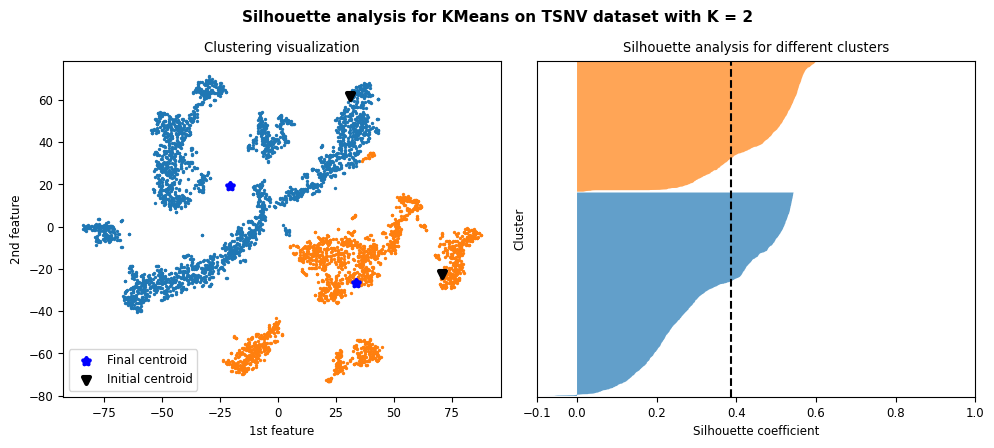

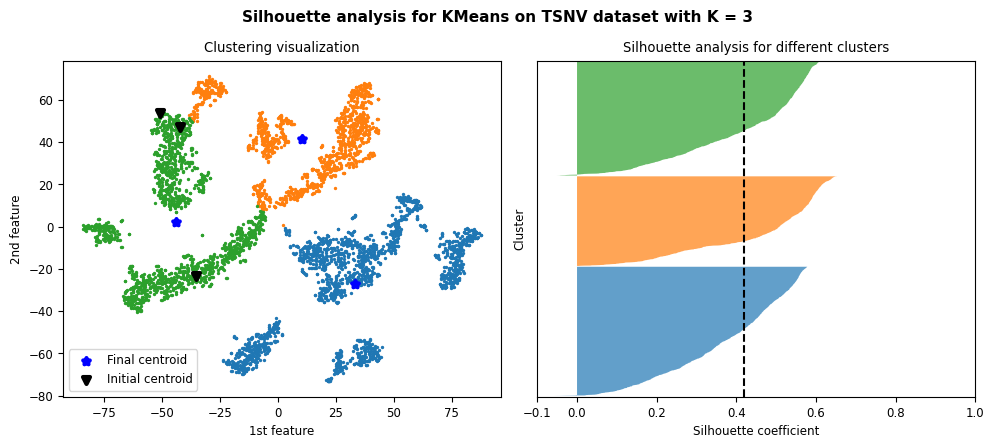

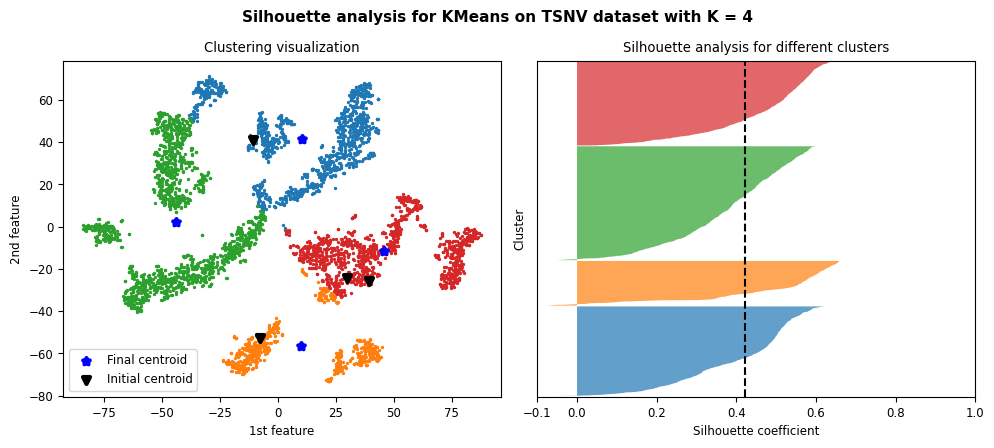

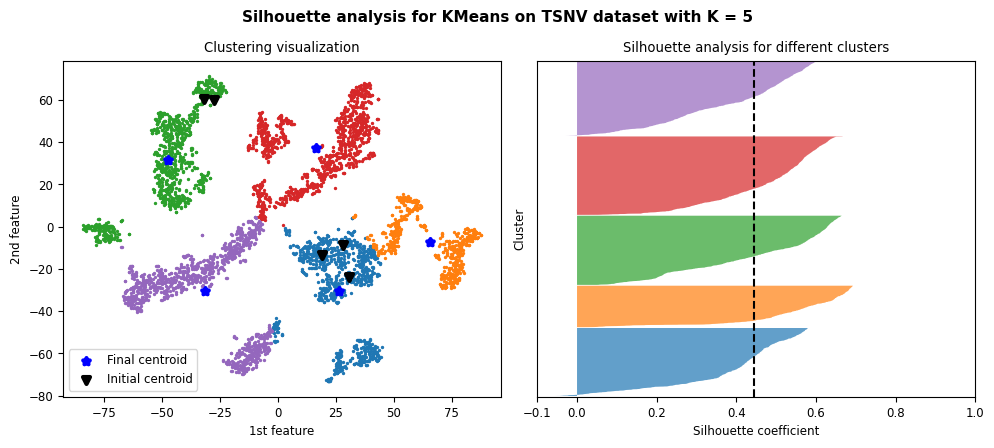

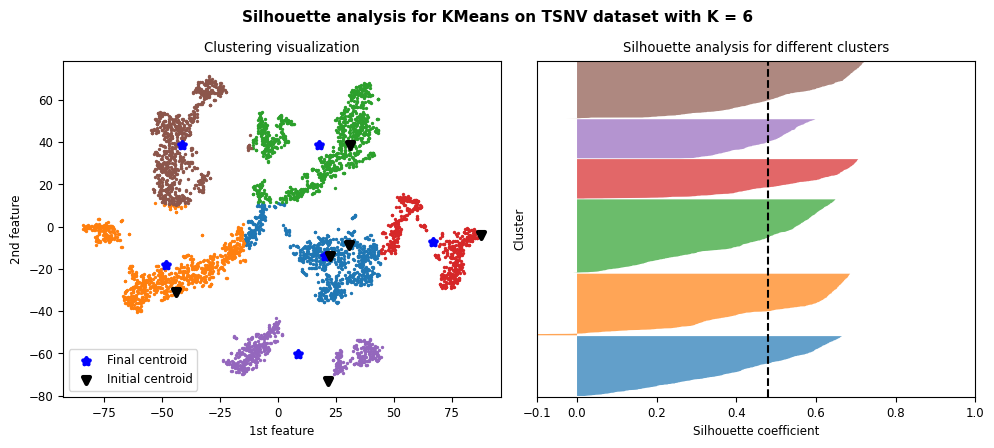

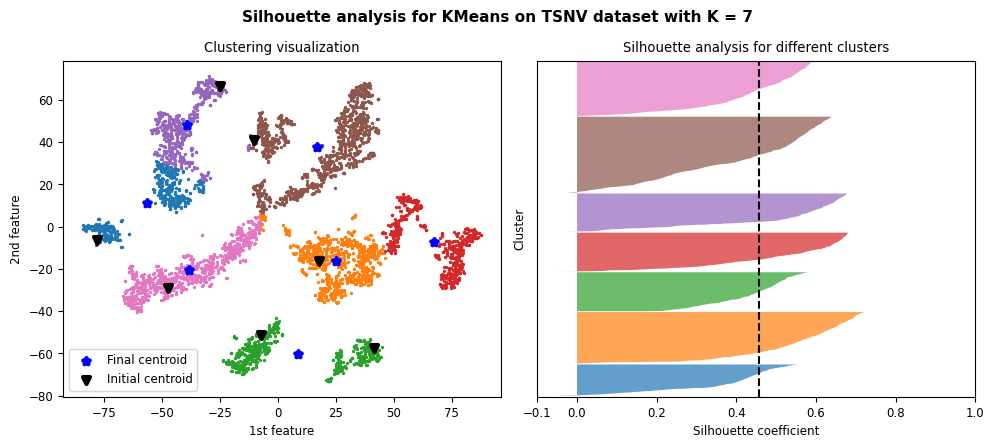

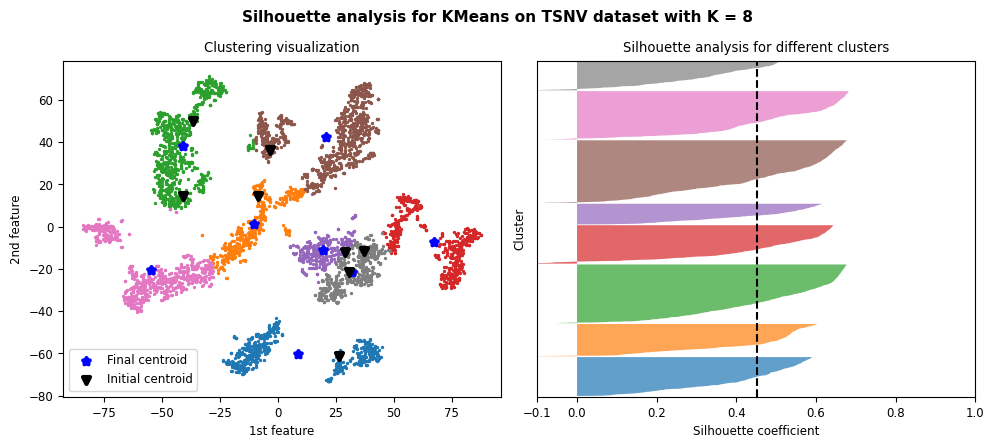

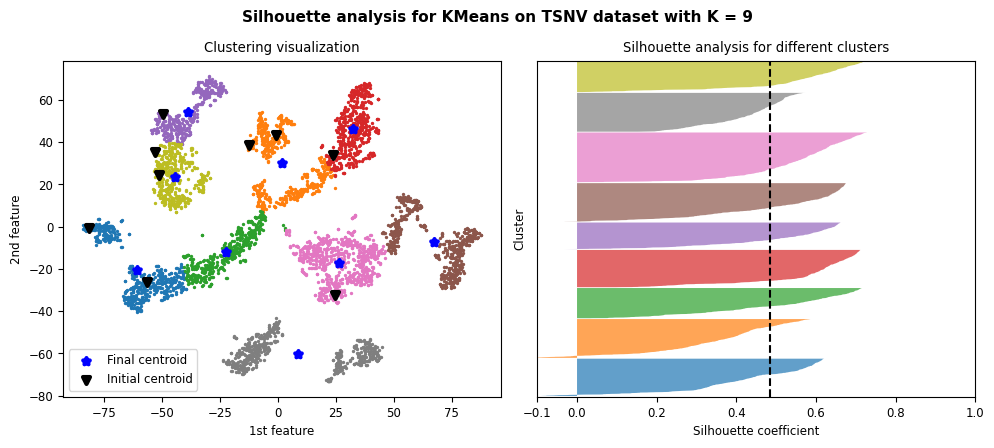

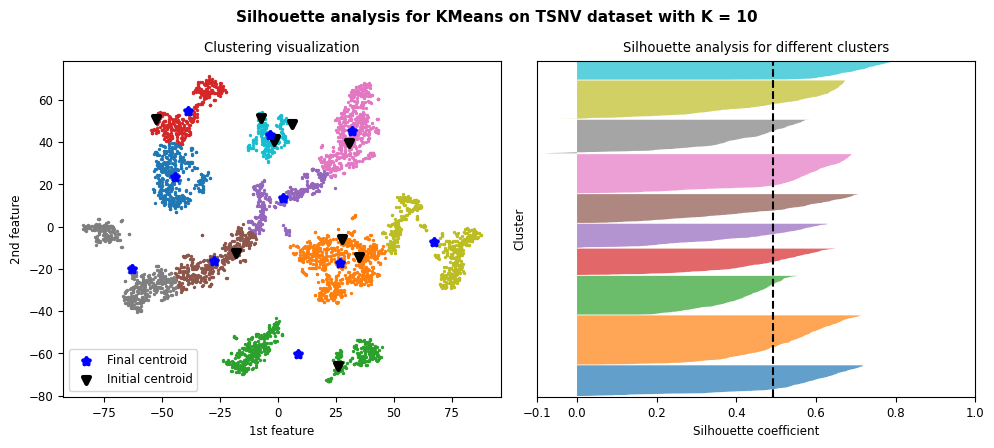

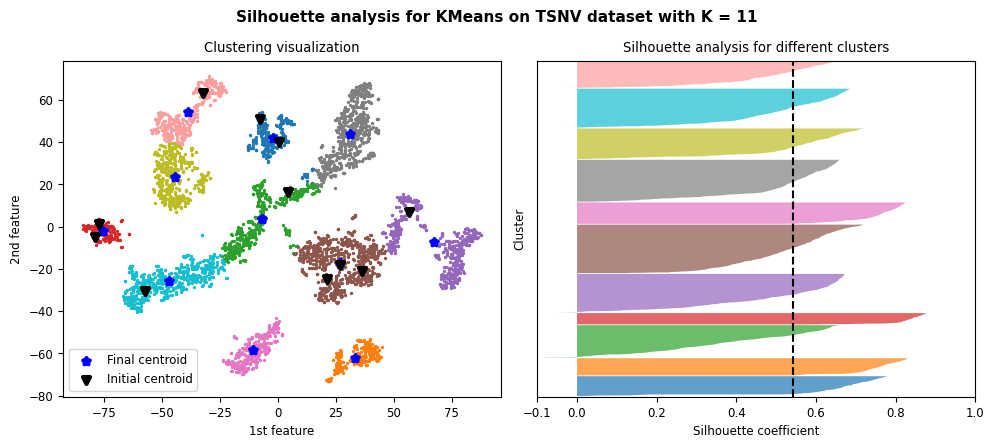

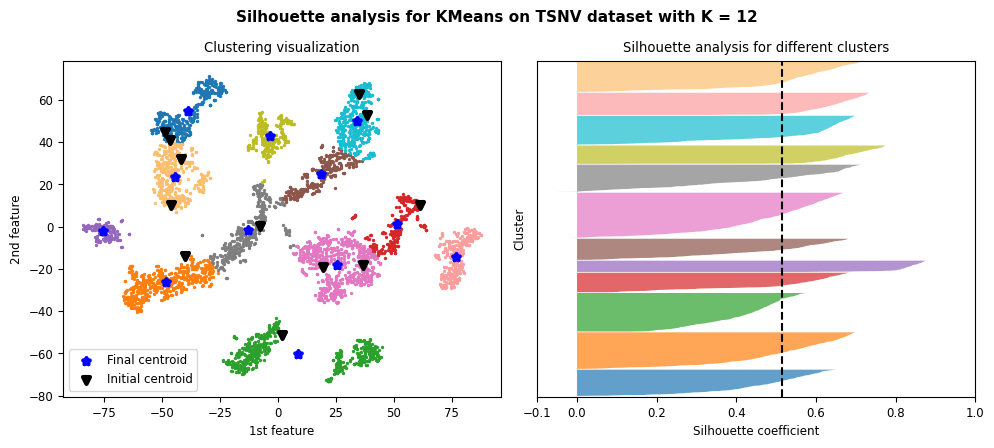

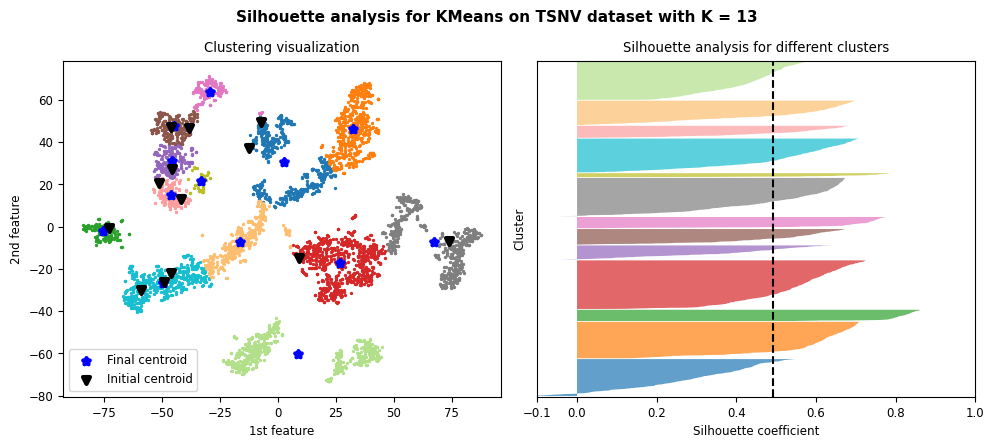

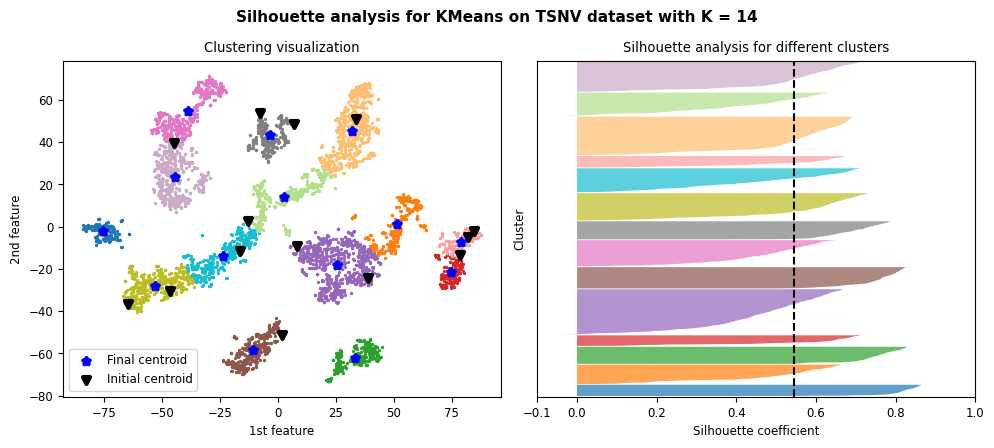

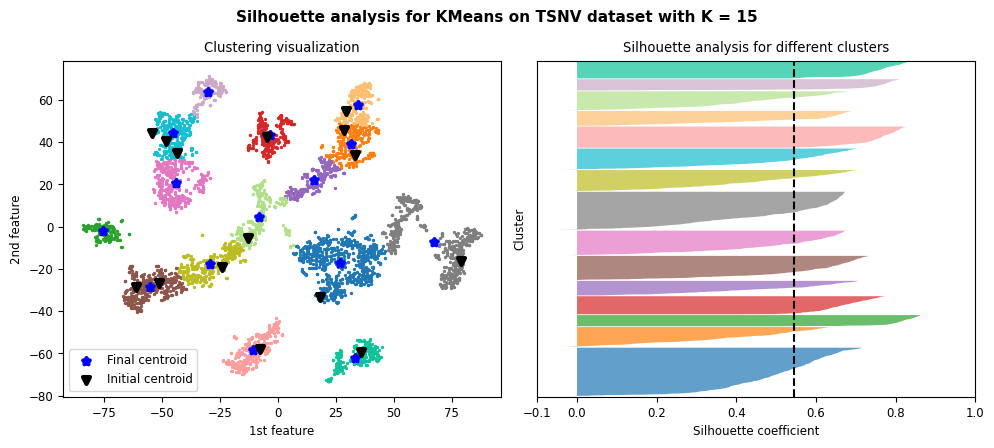

In [215]:
silhouette_scores_manual = []
silhouette_scores_lib = []
distortion_scores = []
times = []
for i in range(1, 16):
    model = KMeans(n_clusters = i, max_iterations=100, cent_init_method='random')
    model.fit(data)
    distortion_scores.append(model.inertia)
    times.append(model.fit_time)
    # Valid values for silhouette_scores are 2 to n_samples - 1 (inclusive)
    if(i > 1):
        silhouette_scores_manual.append(model.silhouette_score())
        silhouette_scores_lib.append(metrics.silhouette_score(data, model.labels, metric='euclidean'))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
        model.plot_results(ax=axs[0])
        model.plot_silhouette(ax=axs[1])
        fig.suptitle(f"Silhouette analysis for KMeans on TSNV dataset with K = {i}", fontsize=11, fontweight="bold")
        plt.tight_layout()

<h4>Elbow method</h4>

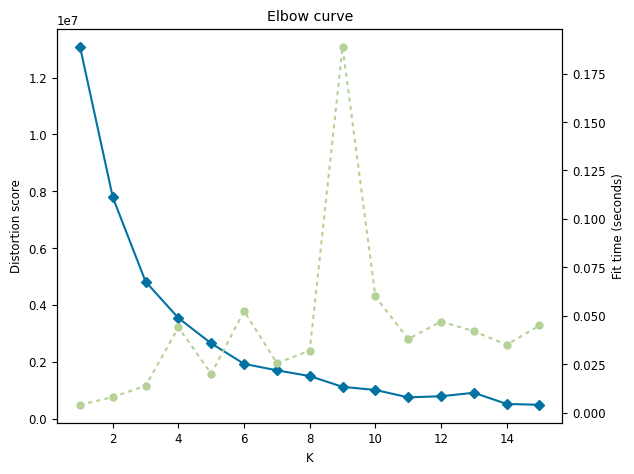

In [216]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax_2 = ax.twinx()
ax_2.plot(x_range, times, color="#B5D197", marker="o", markersize=5, dashes=[2, 2])
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
ax_2.set_ylabel("Fit time (seconds)")
plt.tight_layout()

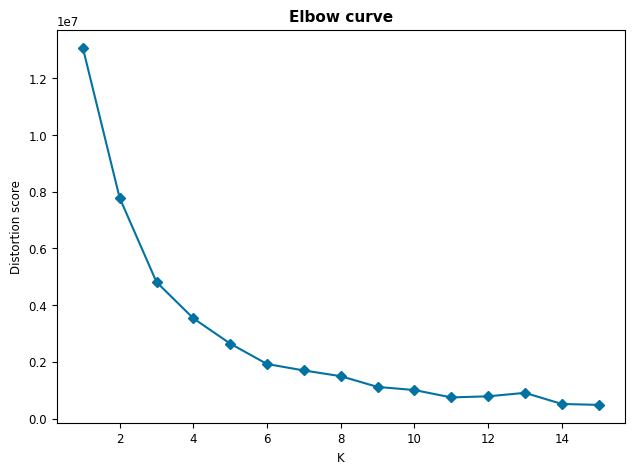

In [217]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax.set_title("Elbow curve", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
plt.tight_layout()

<h3>Silhouette score</h3>

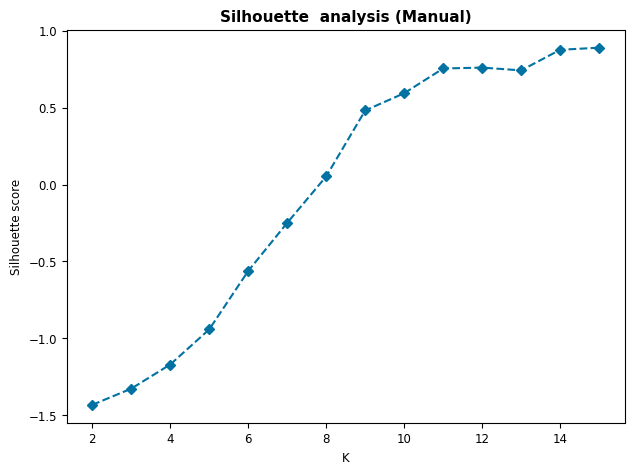

In [218]:
fig, ax = plt.subplots()
x_range = np.arange(2, 16)
ax.plot(x_range, silhouette_scores_manual, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (Manual)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

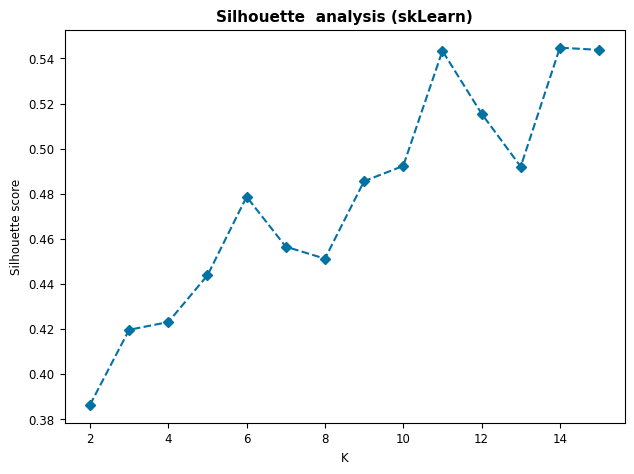

In [219]:
fig, ax = plt.subplots()
ax.plot(x_range, silhouette_scores_lib, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (skLearn)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

<h2>Blobs dataset</h2>

In [227]:
data = pd.read_csv('blobs.csv').to_numpy()
data = data[:, :-1]

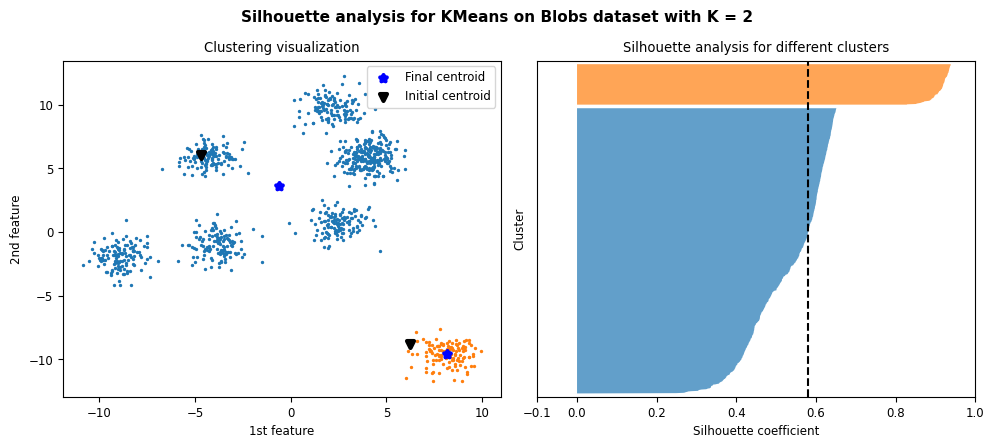

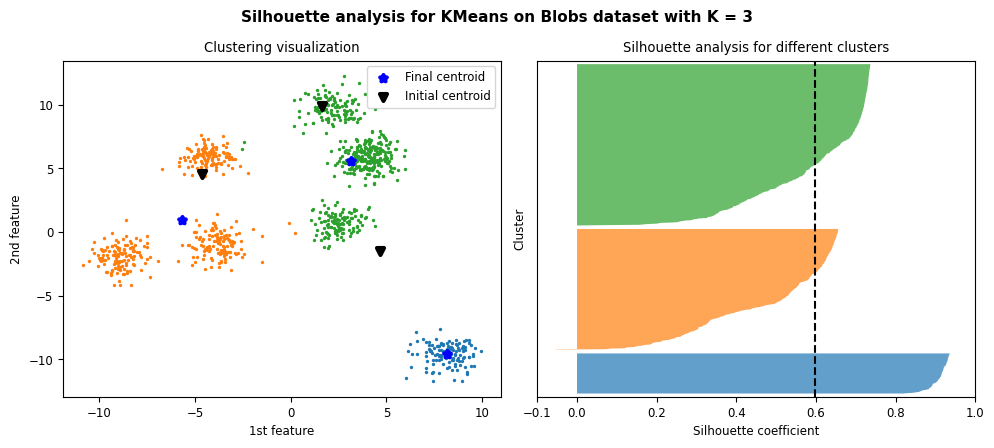

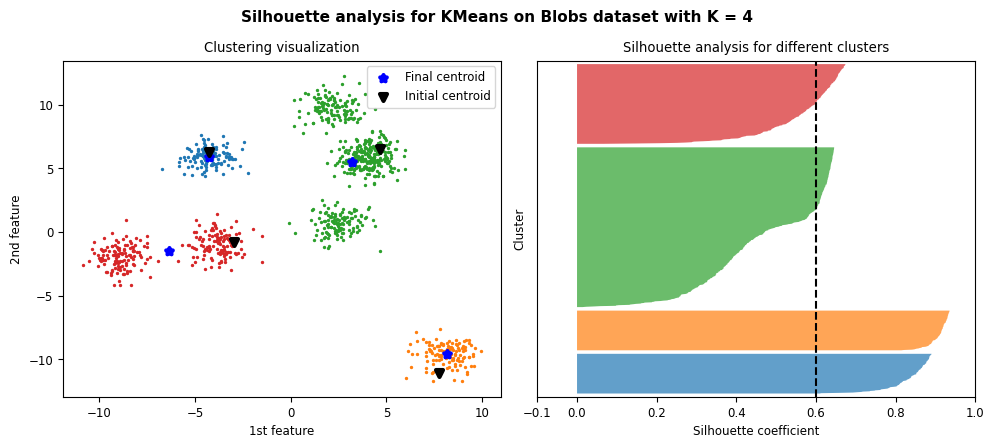

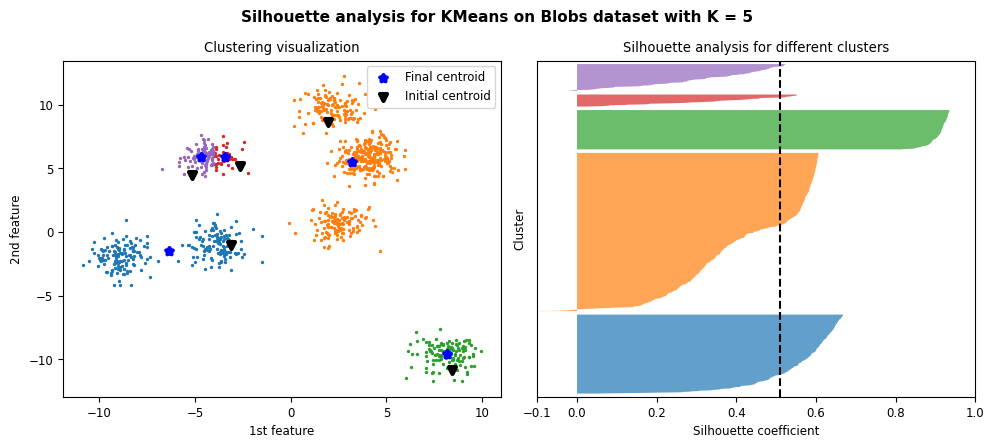

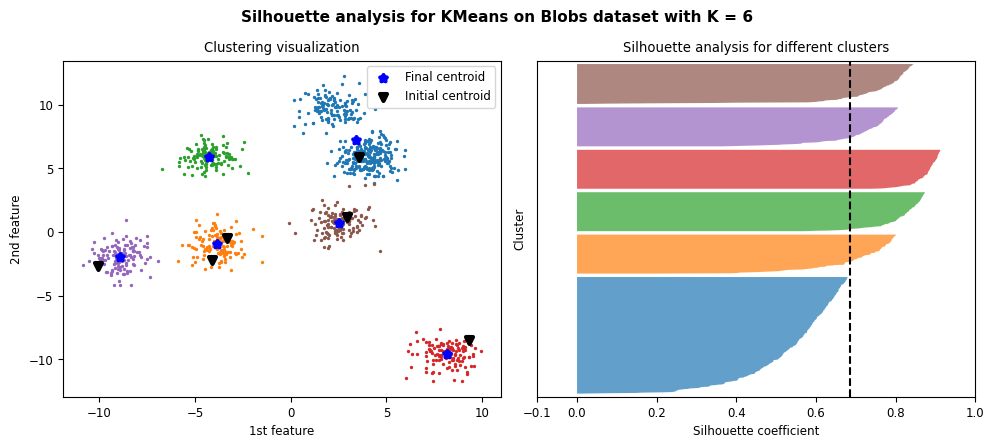

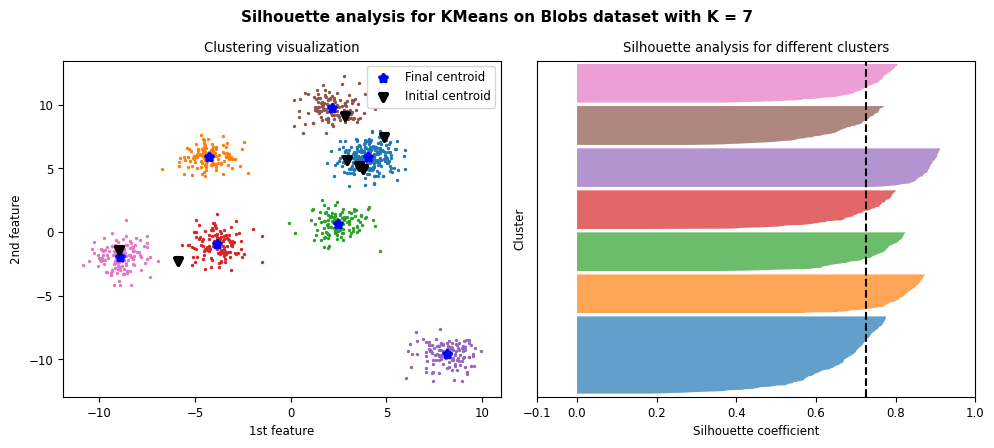

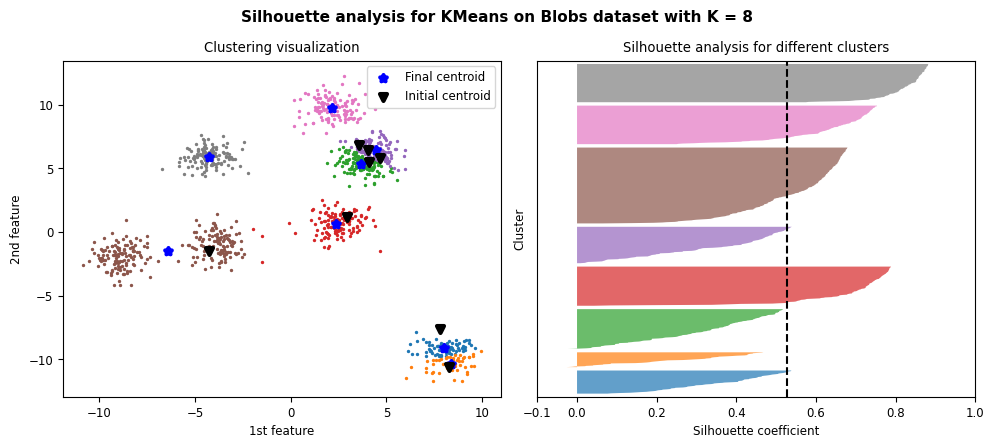

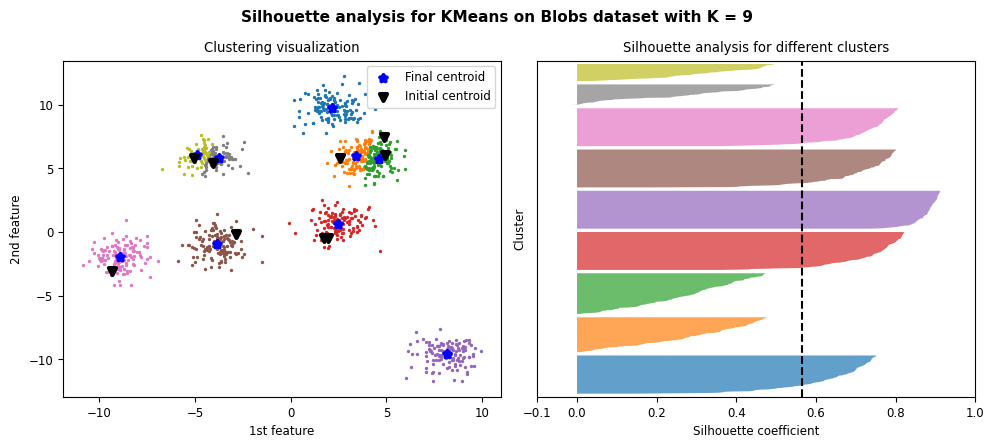

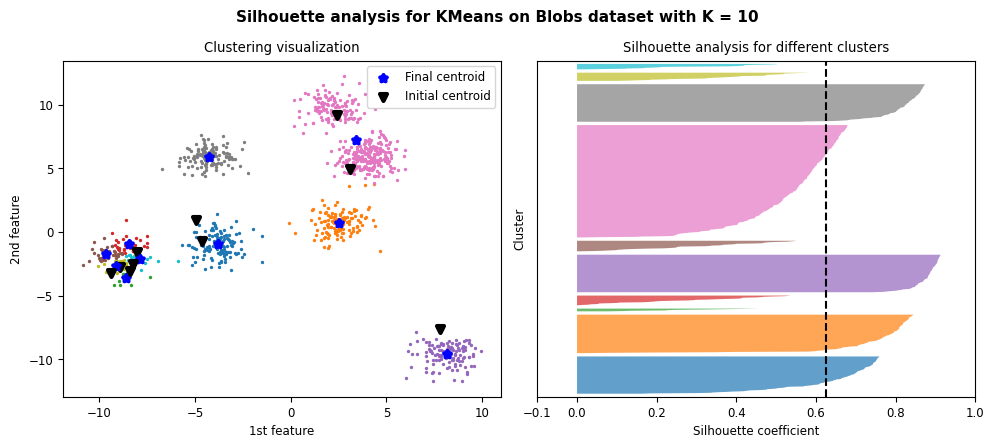

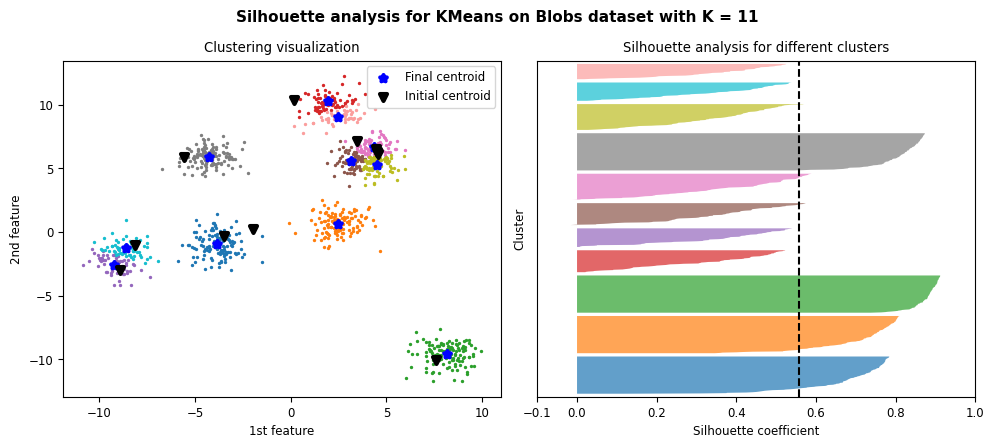

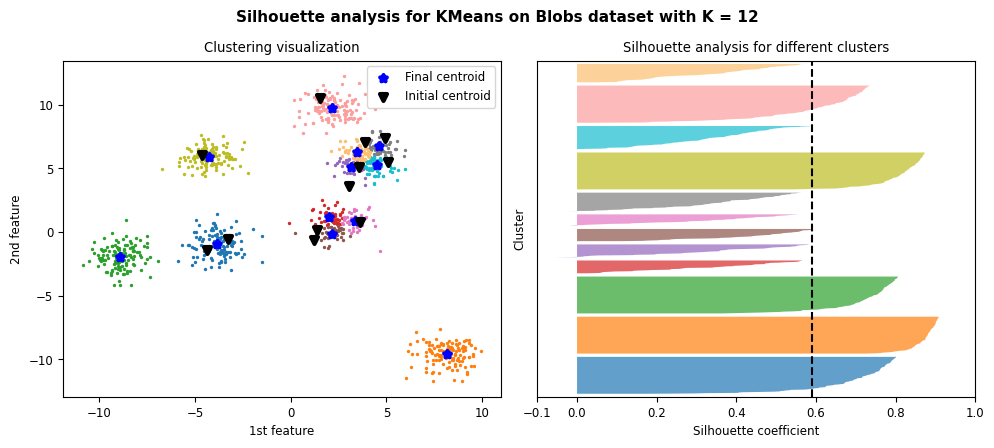

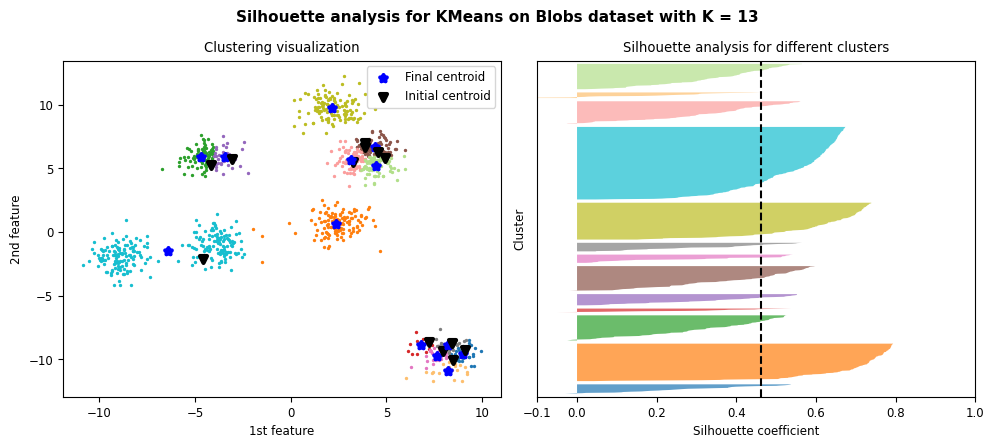

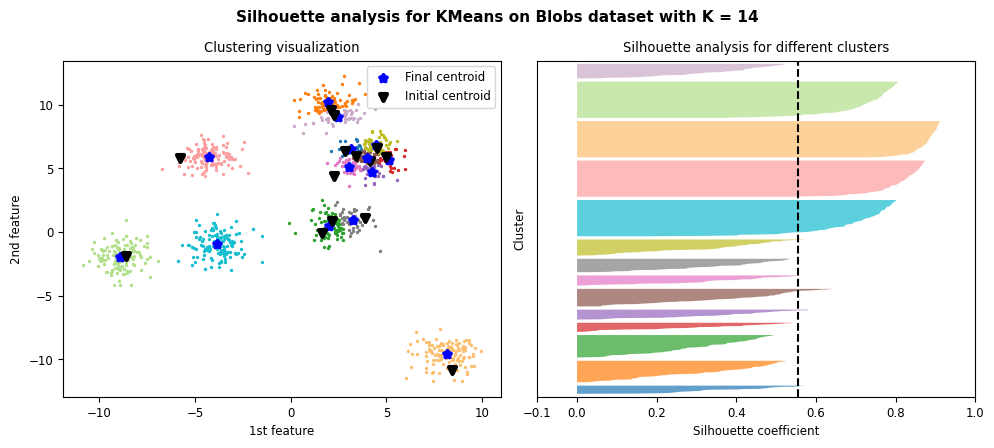

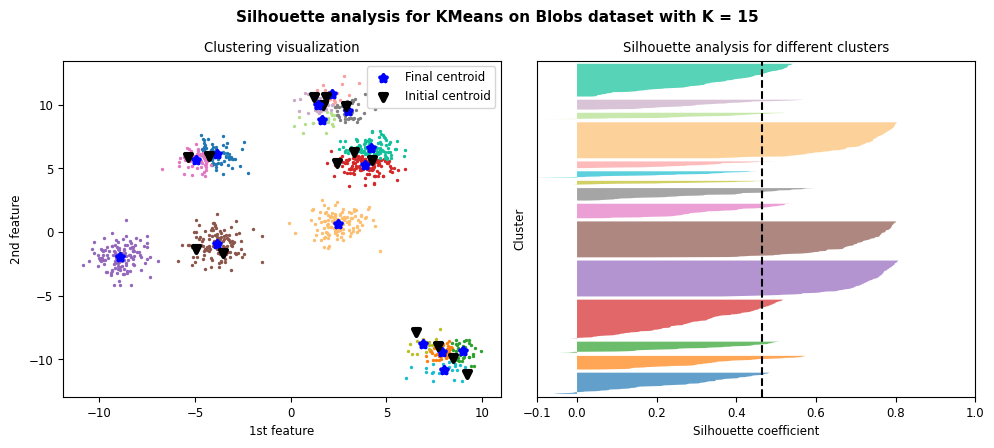

In [233]:
silhouette_scores_manual = []
silhouette_scores_lib = []
distortion_scores = []
times = []
for i in range(1, 16):
    model = KMeans(n_clusters = i, max_iterations=100, cent_init_method='random')
    model.fit(data)
    distortion_scores.append(model.inertia)
    times.append(model.fit_time)
    # Valid values for silhouette_scores are 2 to n_samples - 1 (inclusive)
    if(i > 1):
        silhouette_scores_manual.append(model.silhouette_score())
        silhouette_scores_lib.append(metrics.silhouette_score(data, model.labels, metric='euclidean'))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
        model.plot_results(ax=axs[0])
        model.plot_silhouette(ax=axs[1])
        fig.suptitle(f"Silhouette analysis for KMeans on Blobs dataset with K = {i}", fontsize=11, fontweight="bold")
        plt.tight_layout()

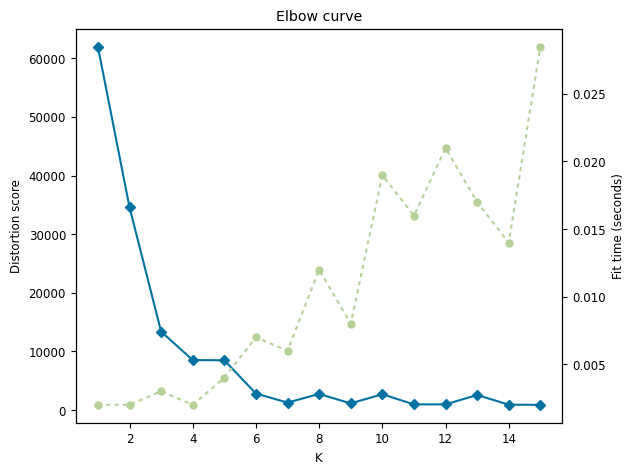

In [234]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax_2 = ax.twinx()
ax_2.plot(x_range, times, color="#B5D197", marker="o", markersize=5, dashes=[2, 2])
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
ax_2.set_ylabel("Fit time (seconds)")
plt.tight_layout()

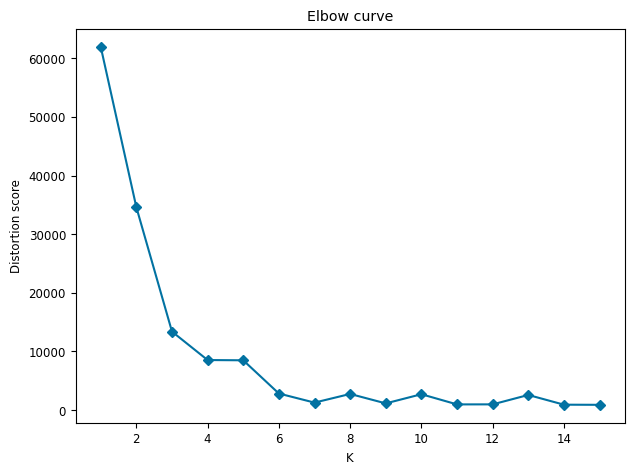

In [237]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
plt.tight_layout()

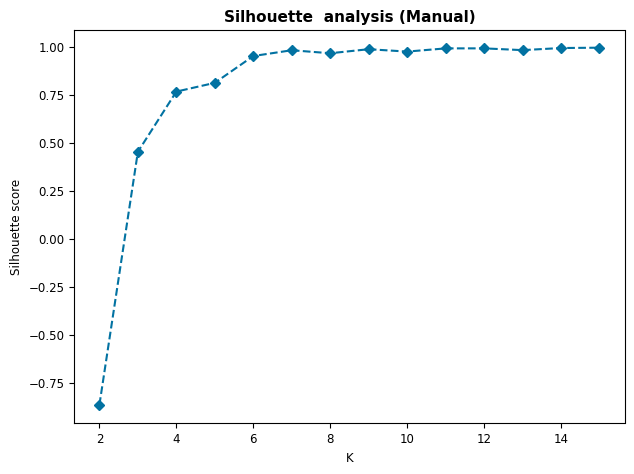

In [235]:
fig, ax = plt.subplots()
x_range = np.arange(2, 16)
ax.plot(x_range, silhouette_scores_manual, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (Manual)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

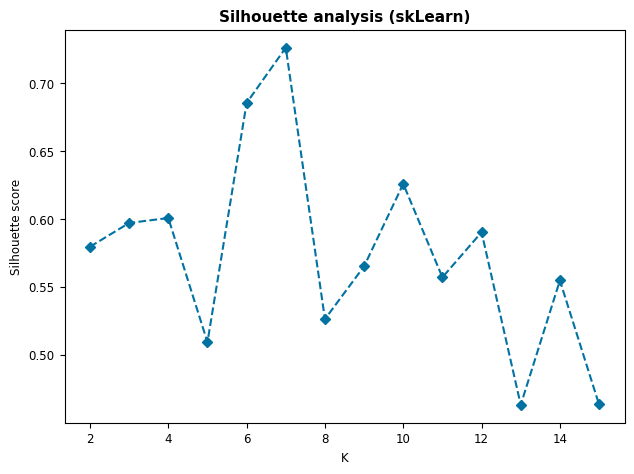

In [236]:
fig, ax = plt.subplots()
ax.plot(x_range, silhouette_scores_lib, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette analysis (skLearn)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

<h2>Elliptical dataset</h2>

In [246]:
data = pd.read_csv('elliptical.csv').to_numpy()
data = data[:, :-1]

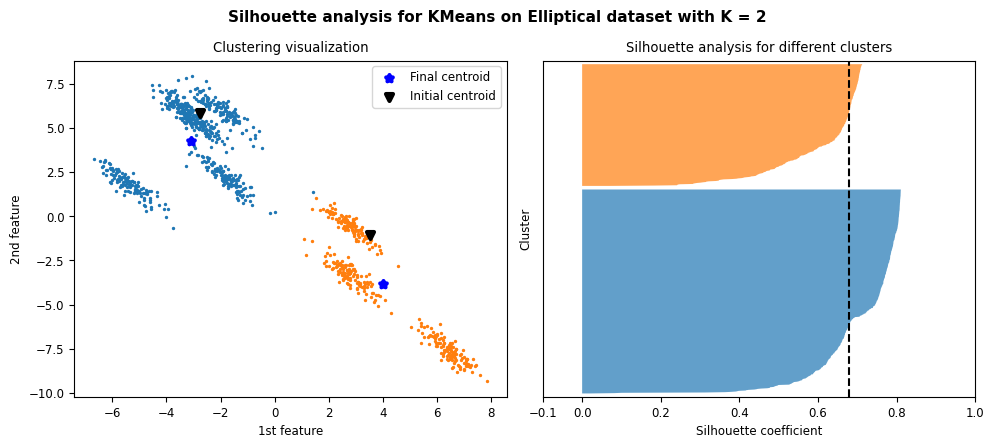

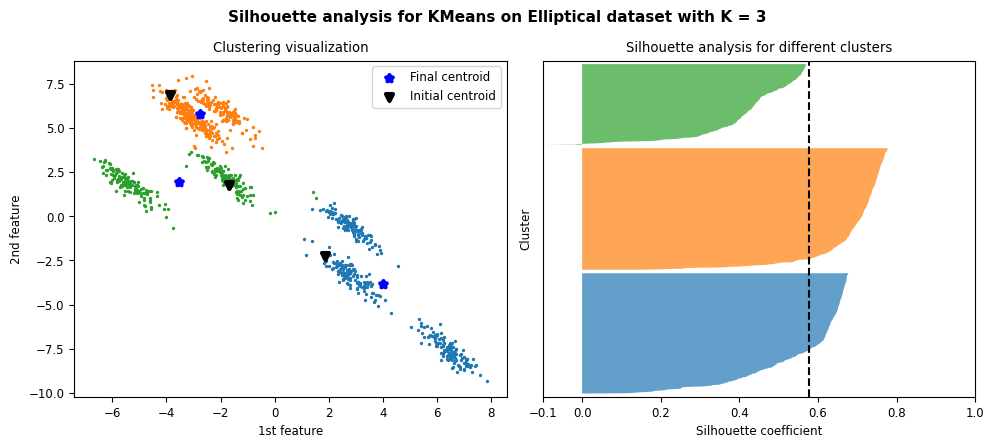

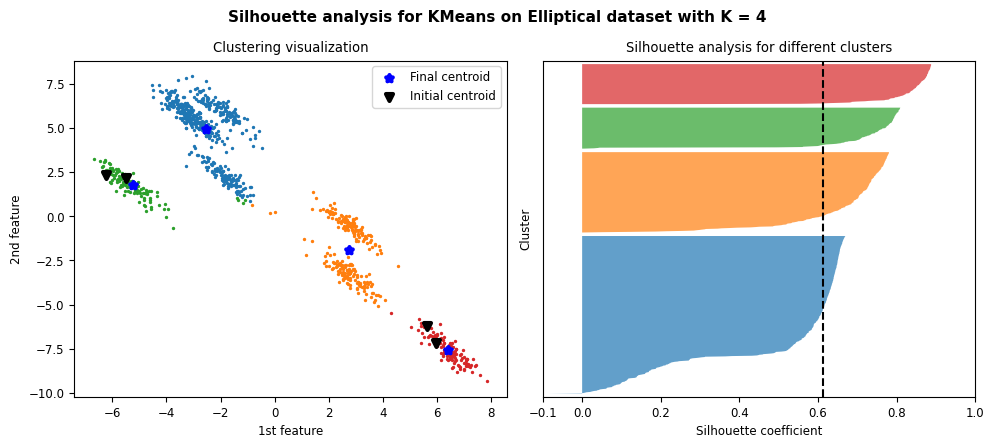

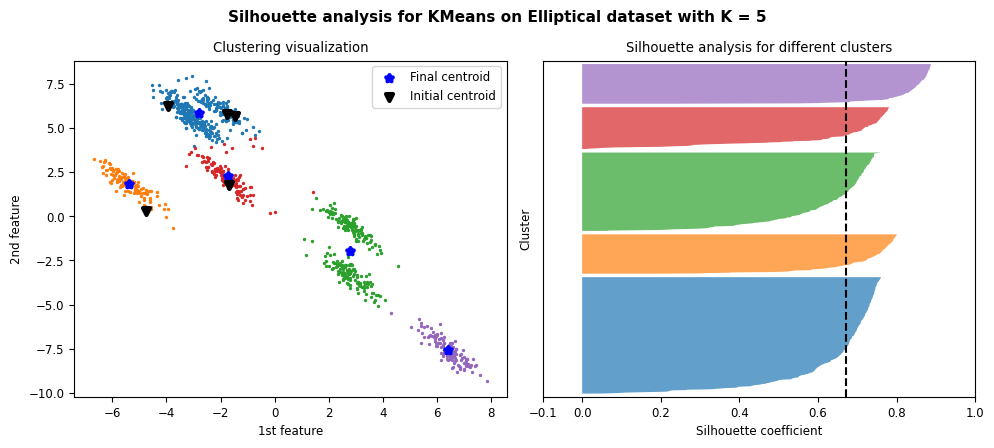

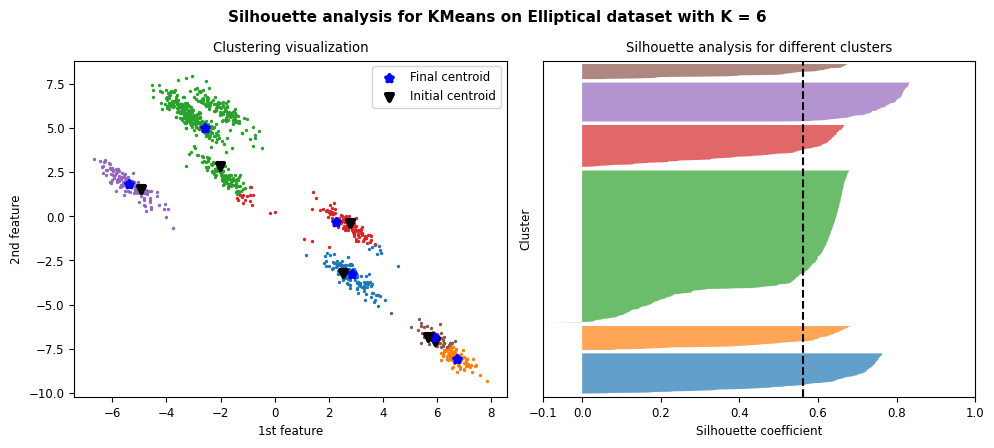

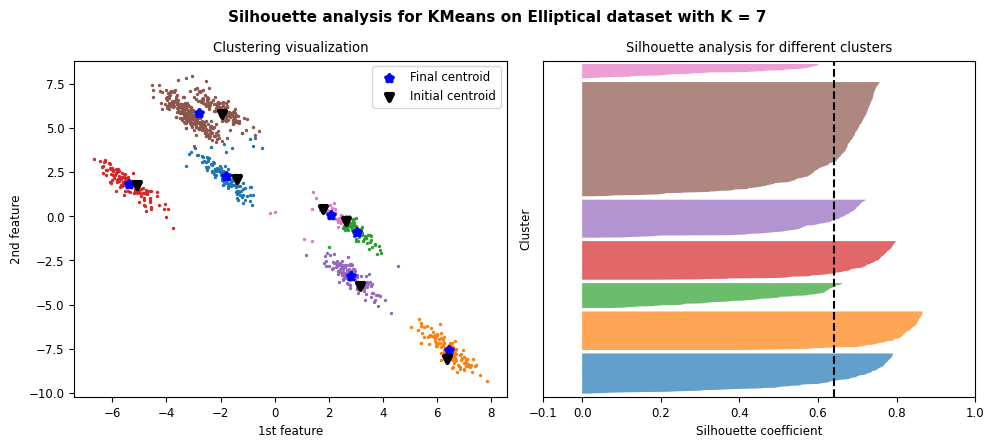

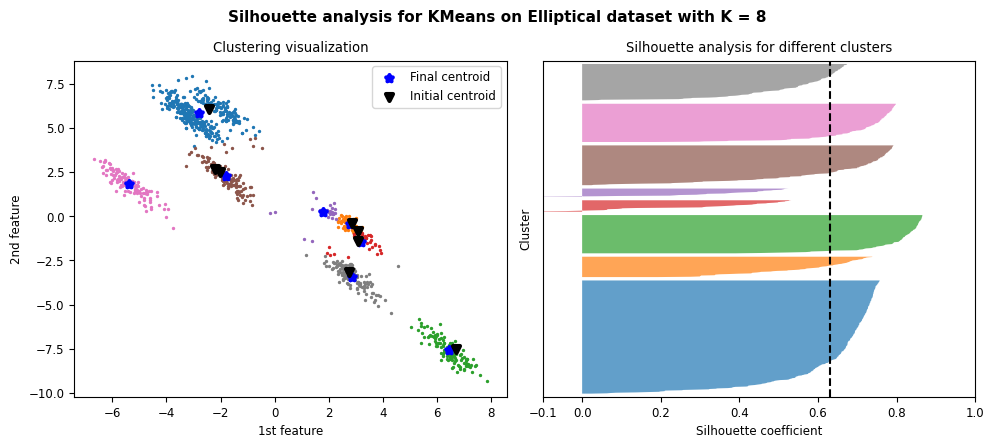

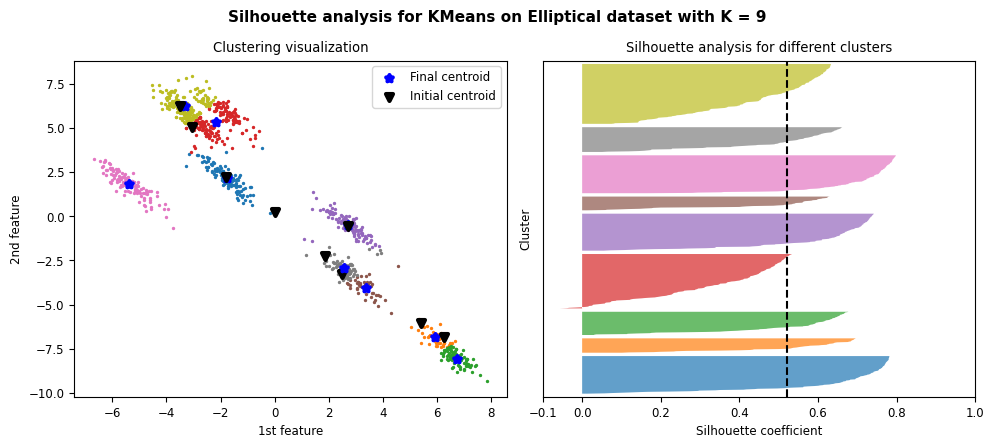

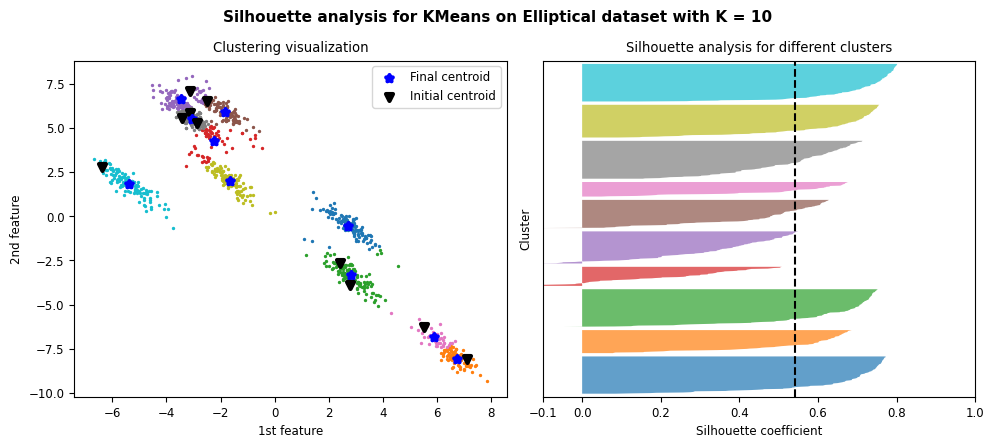

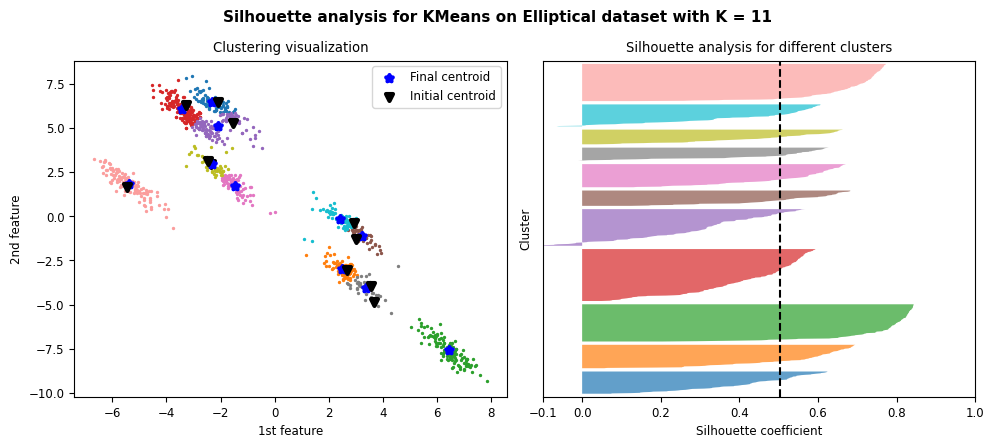

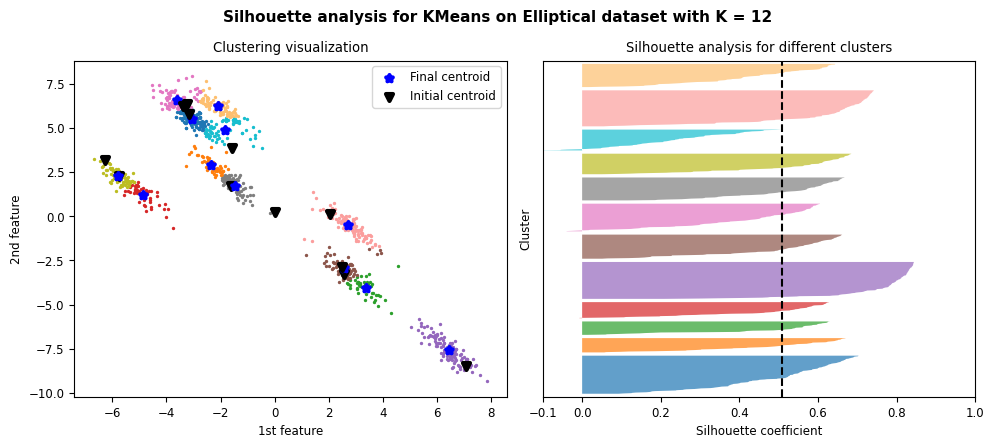

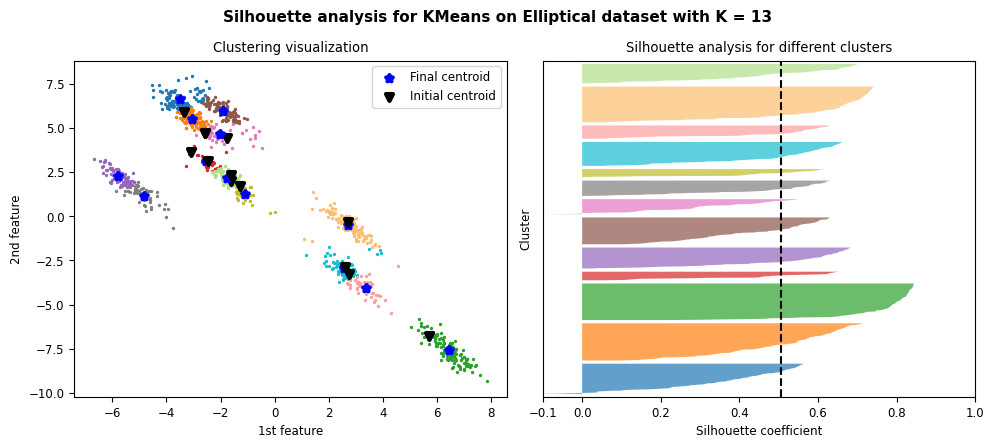

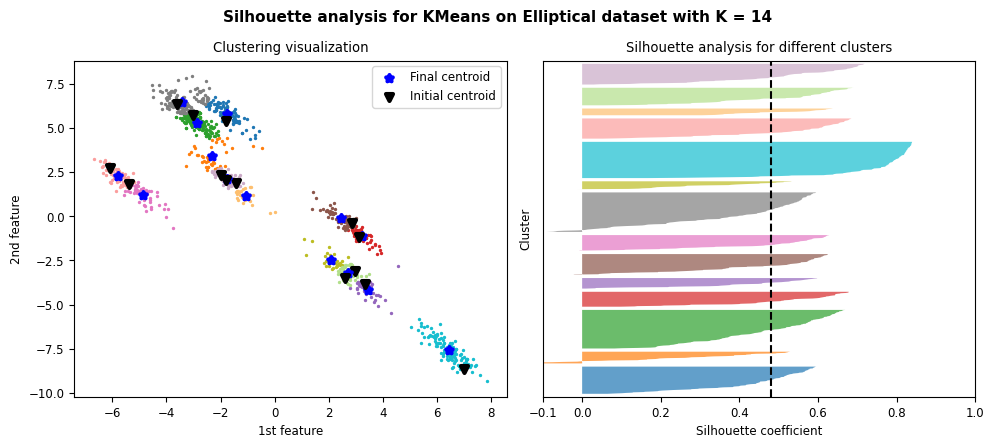

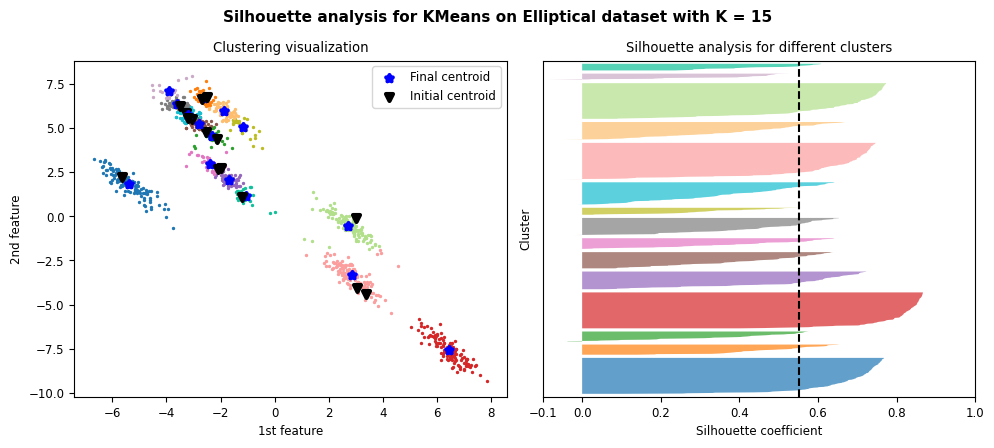

In [247]:
silhouette_scores_manual = []
silhouette_scores_lib = []
distortion_scores = []
times = []
for i in range(1, 16):
    model = KMeans(n_clusters = i, max_iterations=100, cent_init_method='random')
    model.fit(data)
    distortion_scores.append(model.inertia)
    times.append(model.fit_time)
    # Valid values for silhouette_scores are 2 to n_samples - 1 (inclusive)
    if(i > 1):
        silhouette_scores_manual.append(model.silhouette_score())
        silhouette_scores_lib.append(metrics.silhouette_score(data, model.labels, metric='euclidean'))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
        model.plot_results(ax=axs[0])
        model.plot_silhouette(ax=axs[1])
        fig.suptitle(f"Silhouette analysis for KMeans on Elliptical dataset with K = {i}", fontsize=11, fontweight="bold")
        plt.tight_layout()

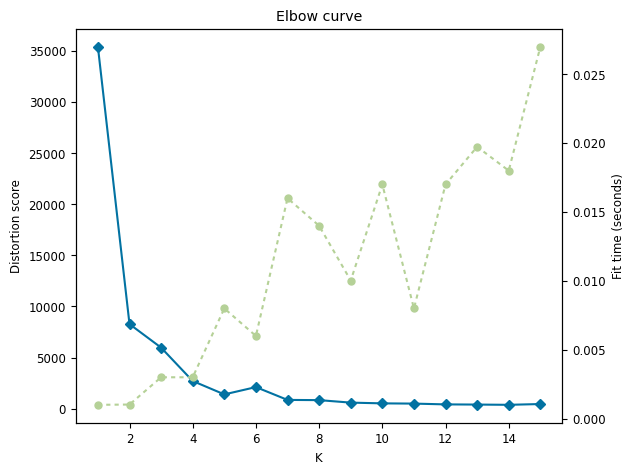

In [248]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax_2 = ax.twinx()
ax_2.plot(x_range, times, color="#B5D197", marker="o", markersize=5, dashes=[2, 2])
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
ax_2.set_ylabel("Fit time (seconds)")
plt.tight_layout()

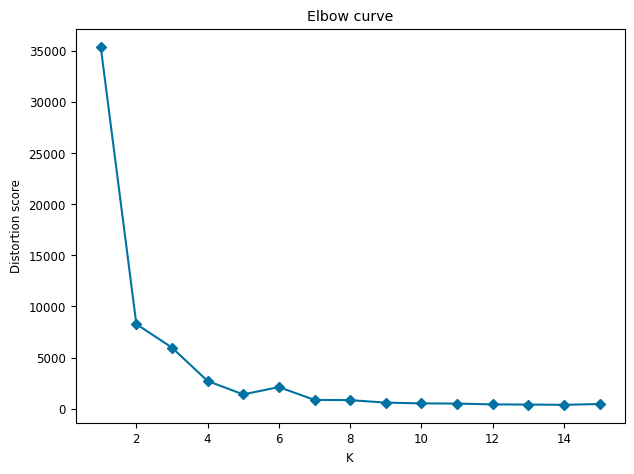

In [249]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
plt.tight_layout()

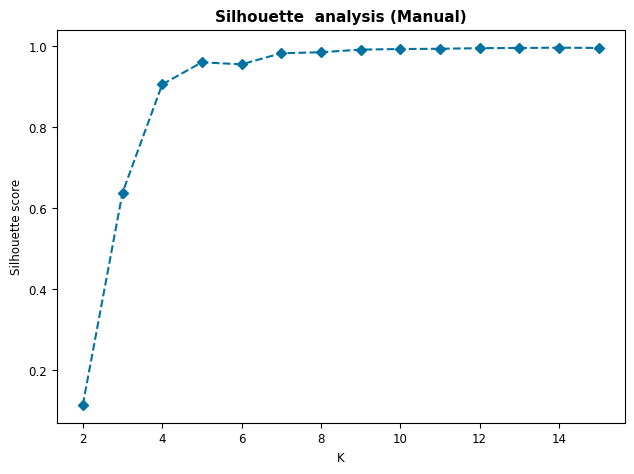

In [250]:
fig, ax = plt.subplots()
x_range = np.arange(2, 16)
ax.plot(x_range, silhouette_scores_manual, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (Manual)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

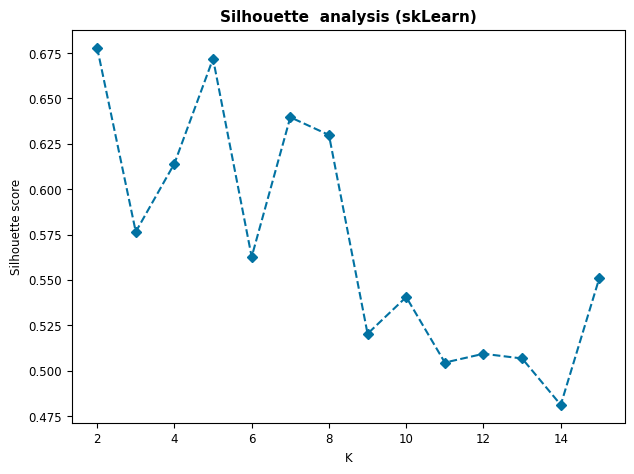

In [251]:
fig, ax = plt.subplots()
ax.plot(x_range, silhouette_scores_lib, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (skLearn)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

<h2>Moon dataset</h2>

In [252]:
data = pd.read_csv('moon.csv').to_numpy()
data = data[:, :-1]

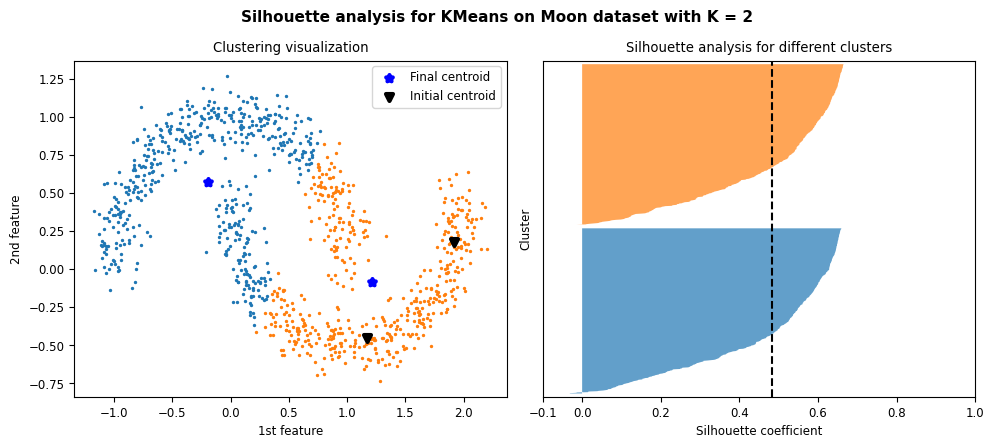

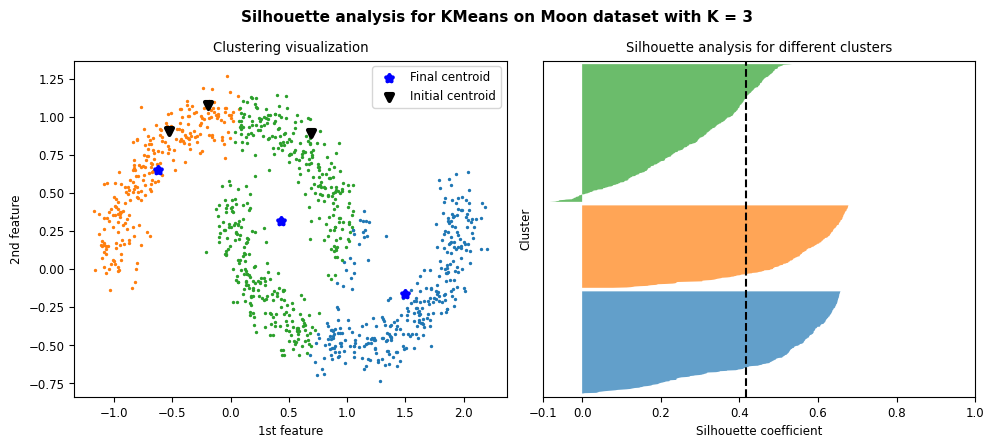

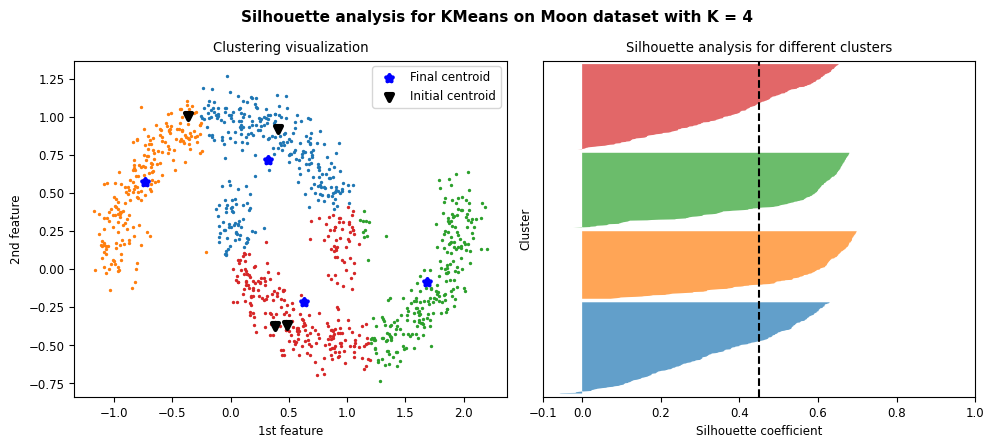

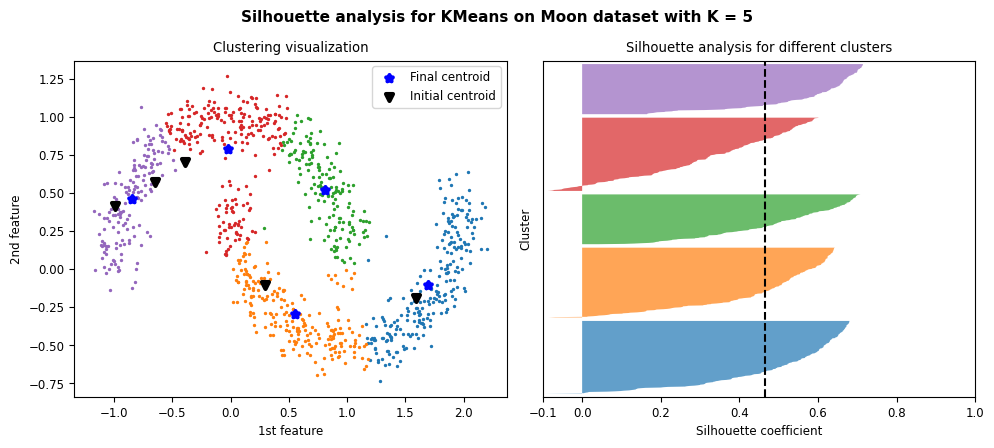

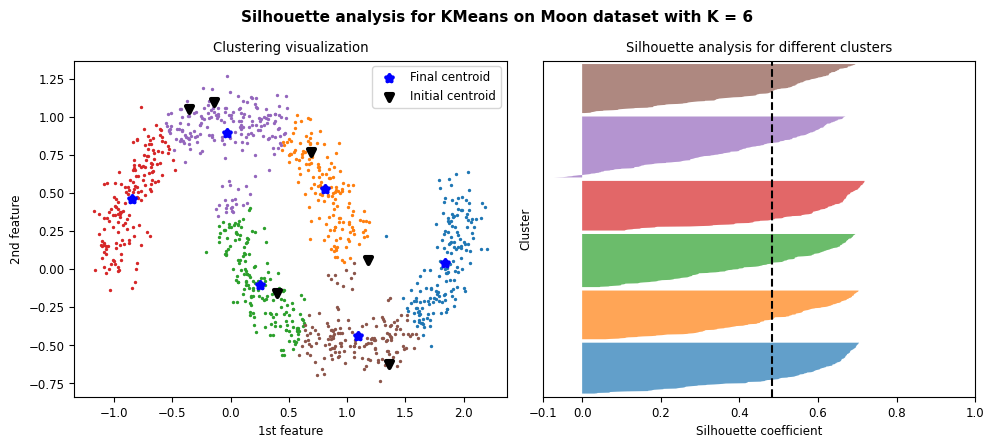

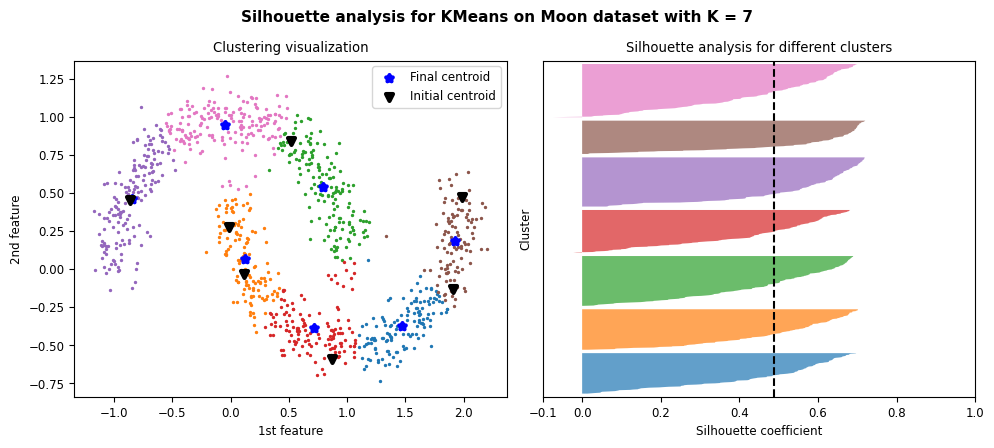

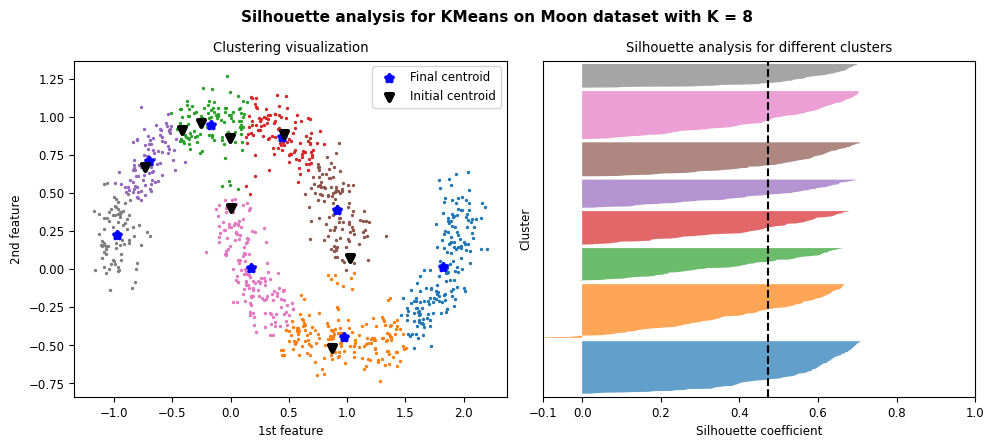

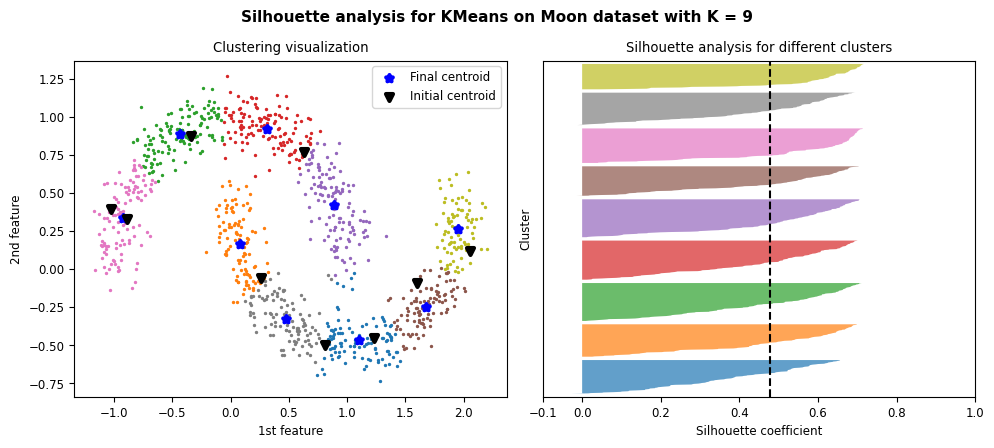

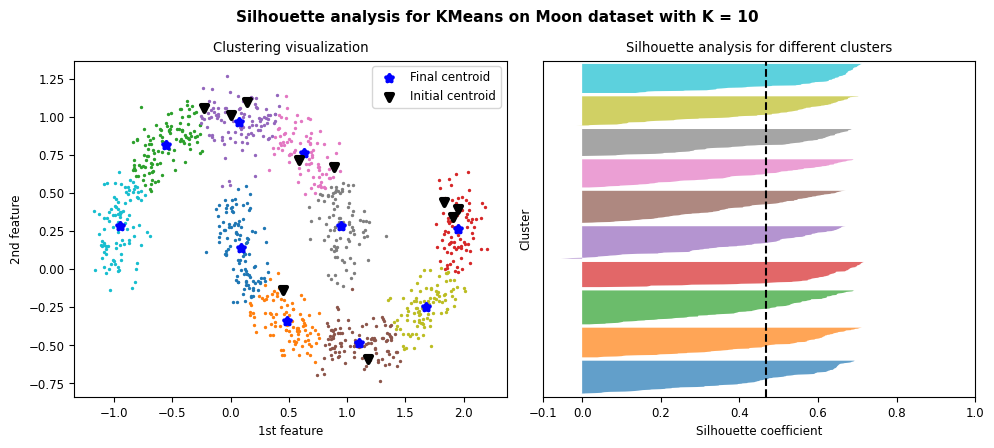

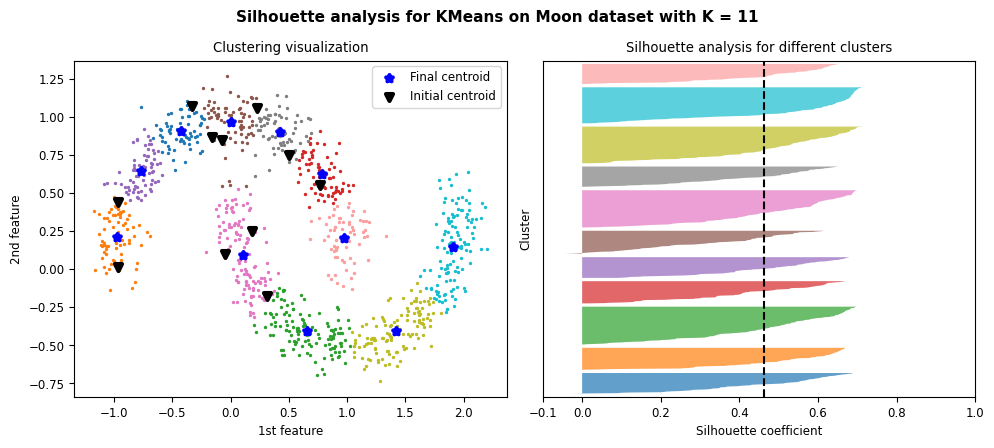

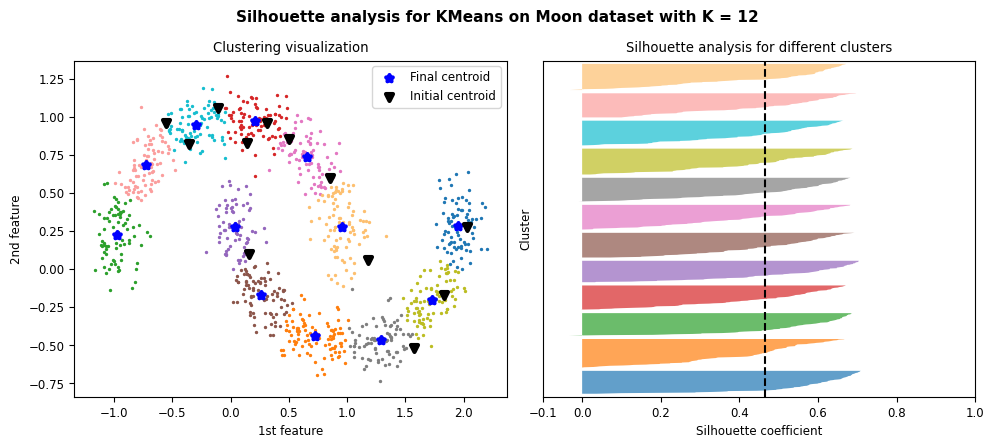

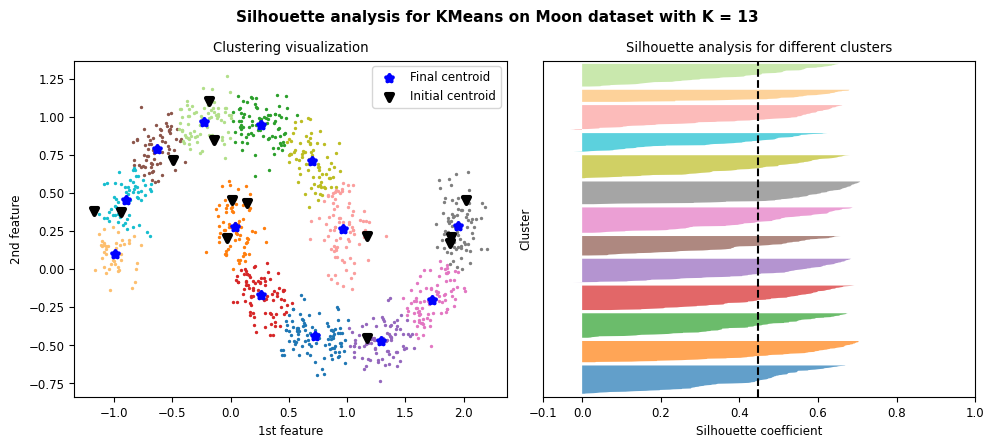

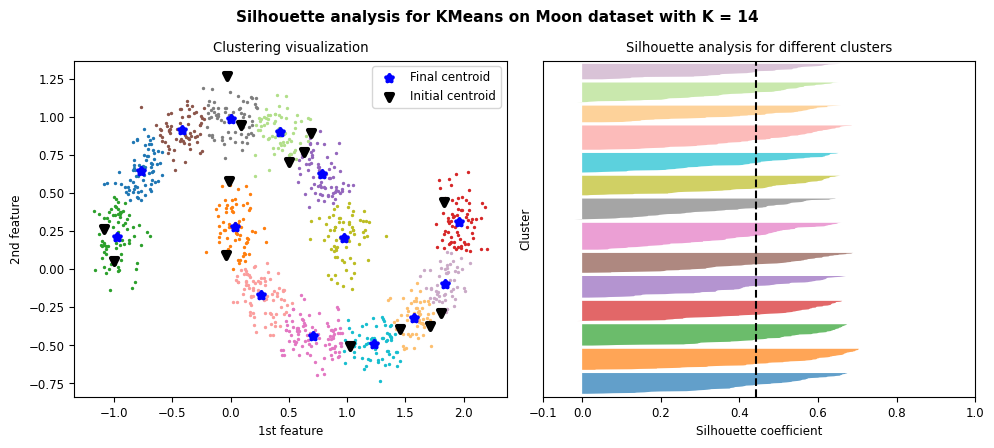

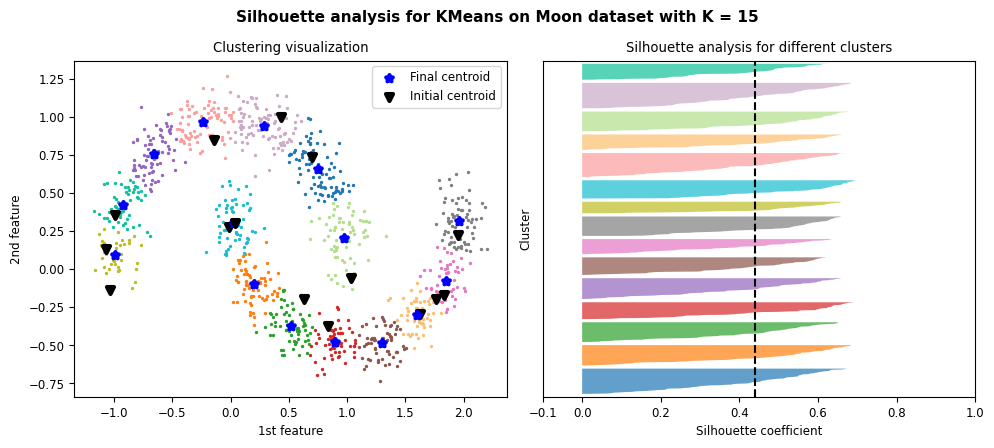

In [263]:
silhouette_scores_manual = []
silhouette_scores_lib = []
distortion_scores = []
times = []
for i in range(1, 16):
    model = KMeans(n_clusters = i, max_iterations=100, cent_init_method='random')
    model.fit(data)
    distortion_scores.append(model.inertia)
    times.append(model.fit_time)
    # Valid values for silhouette_scores are 2 to n_samples - 1 (inclusive)
    if(i > 1):
        silhouette_scores_manual.append(model.silhouette_score())
        silhouette_scores_lib.append(metrics.silhouette_score(data, model.labels, metric='euclidean'))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
        model.plot_results(ax=axs[0])
        model.plot_silhouette(ax=axs[1])
        fig.suptitle(f"Silhouette analysis for KMeans on Moon dataset with K = {i}", fontsize=11, fontweight="bold")
        plt.tight_layout()

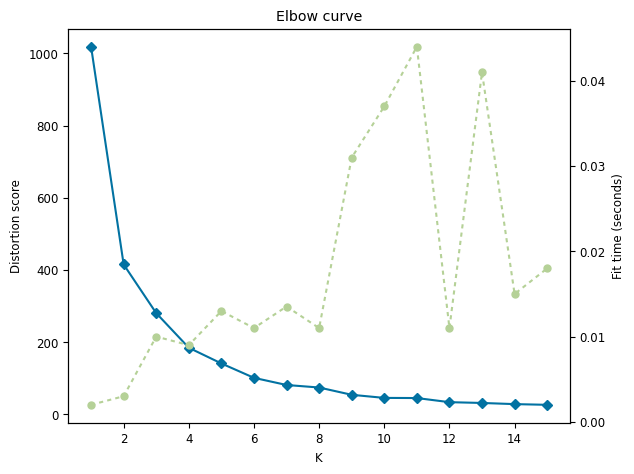

In [264]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax_2 = ax.twinx()
ax_2.plot(x_range, times, color="#B5D197", marker="o", markersize=5, dashes=[2, 2])
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
ax_2.set_ylabel("Fit time (seconds)")
plt.tight_layout()

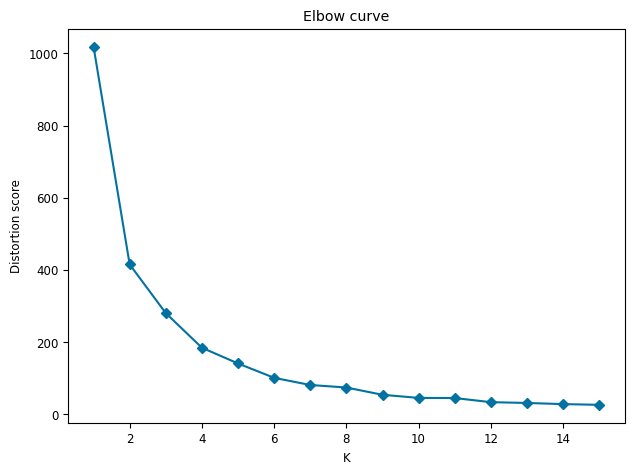

In [265]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
plt.tight_layout()

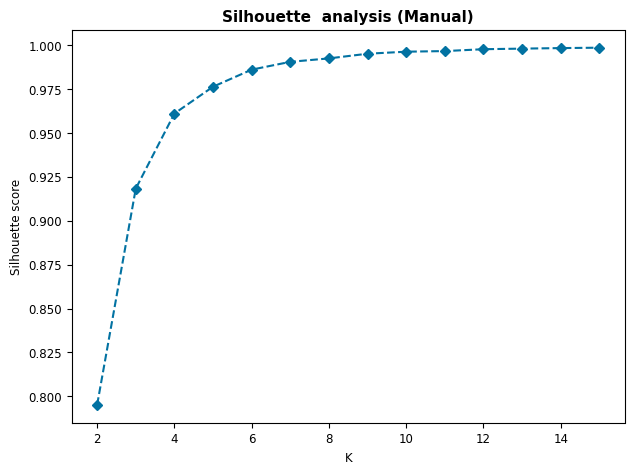

In [267]:
fig, ax = plt.subplots()
x_range = np.arange(2, 16)
ax.plot(x_range, silhouette_scores_manual, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (Manual)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

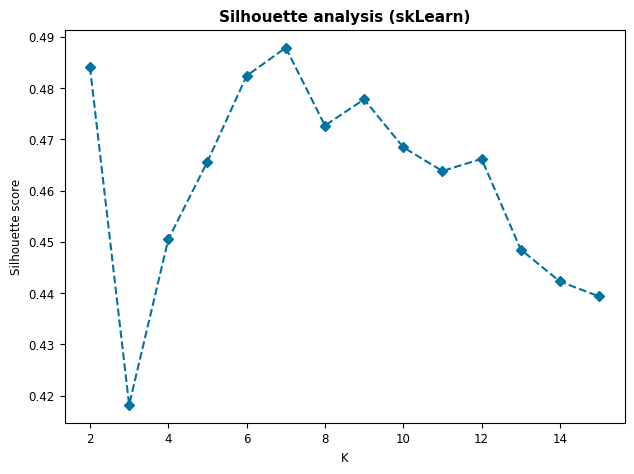

In [269]:
fig, ax = plt.subplots()
ax.plot(x_range, silhouette_scores_lib, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette analysis (skLearn)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

<h2>Circle dataset</h2>

In [270]:
data = pd.read_csv('circle.csv').to_numpy()
data = data[:, :-1]

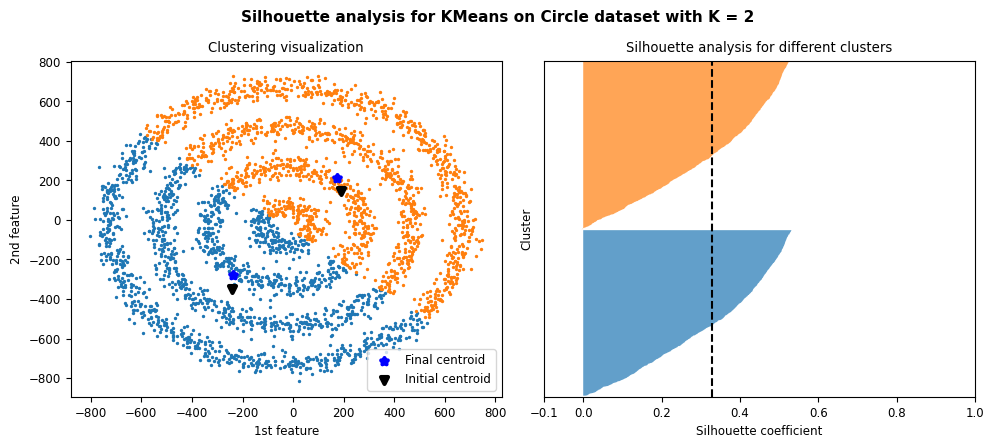

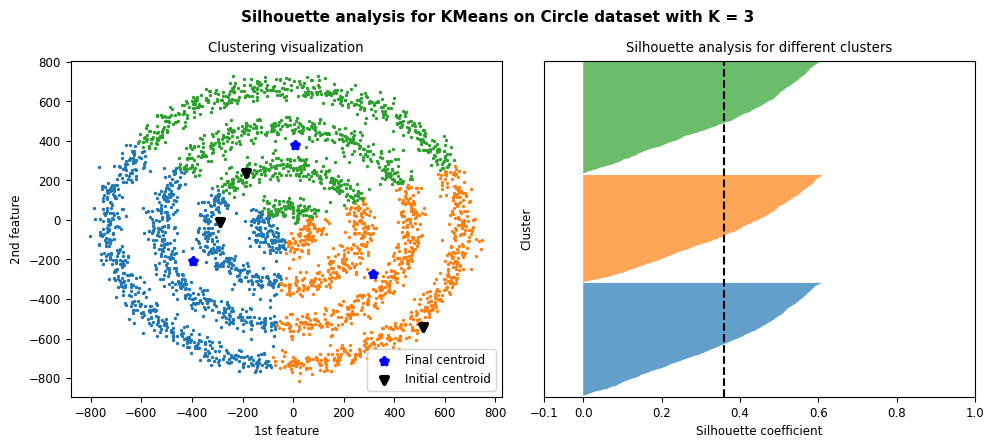

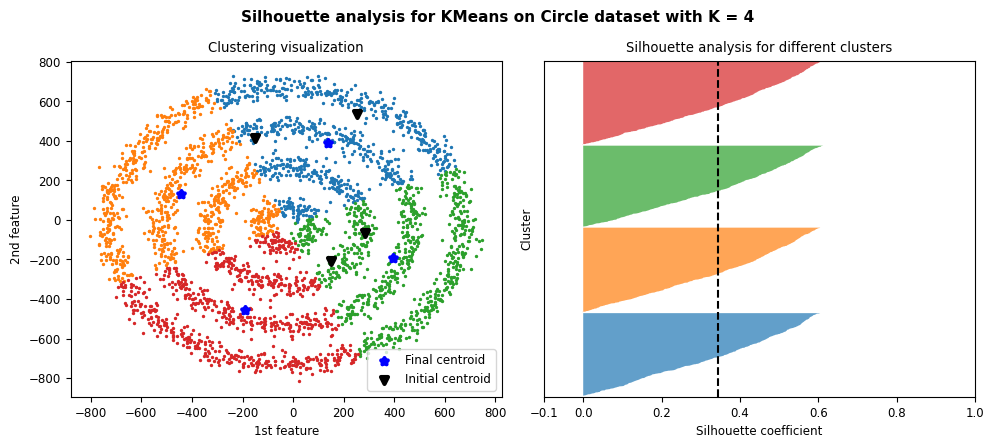

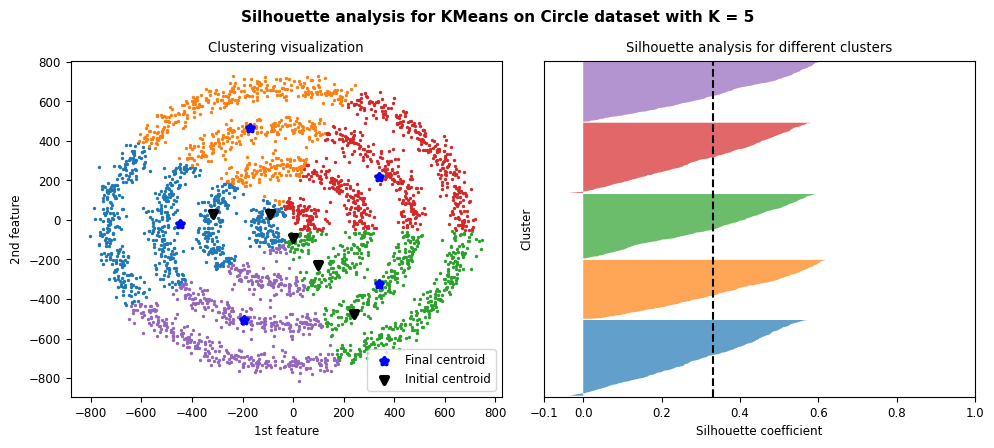

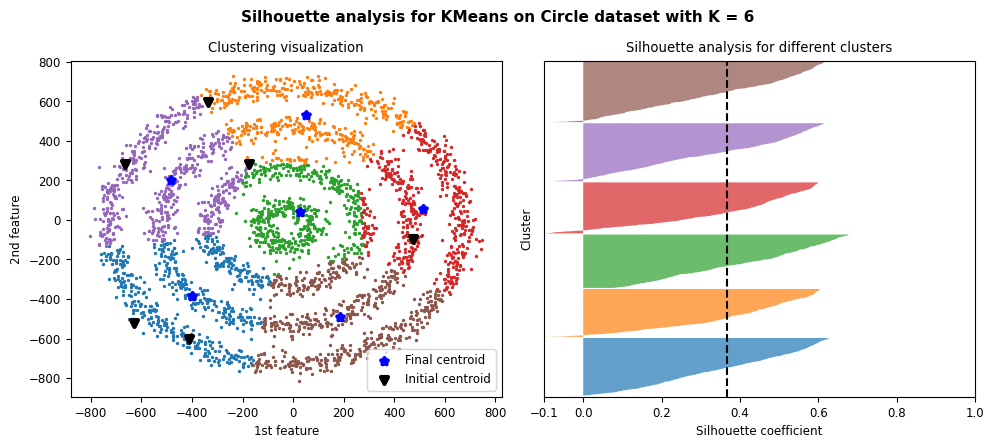

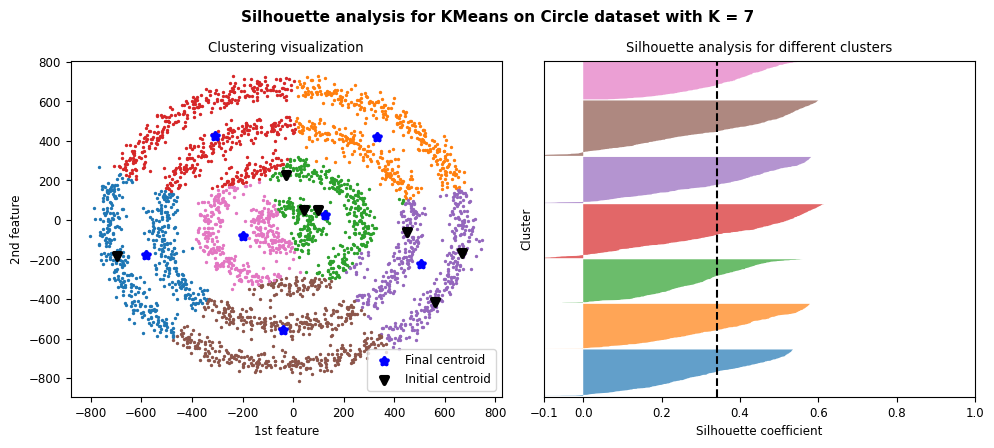

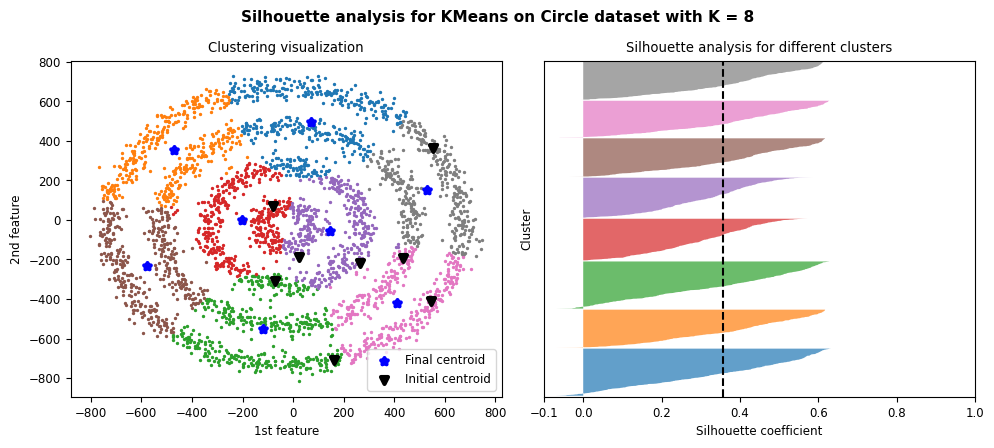

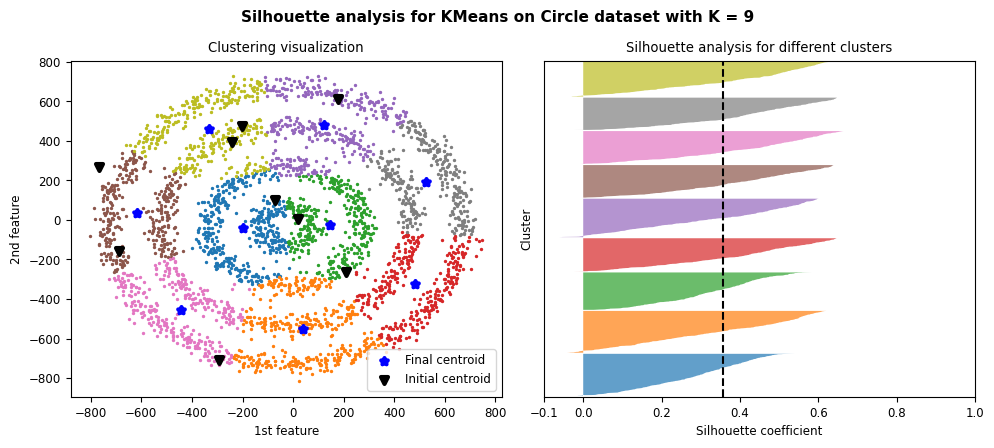

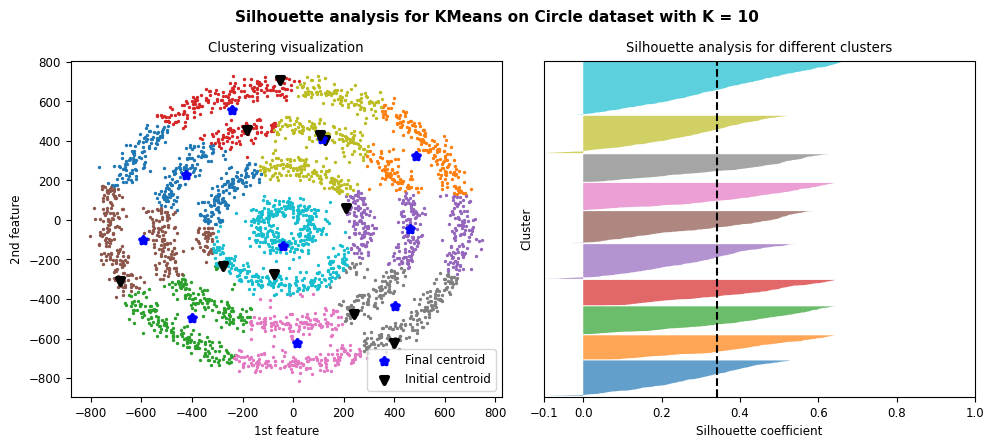

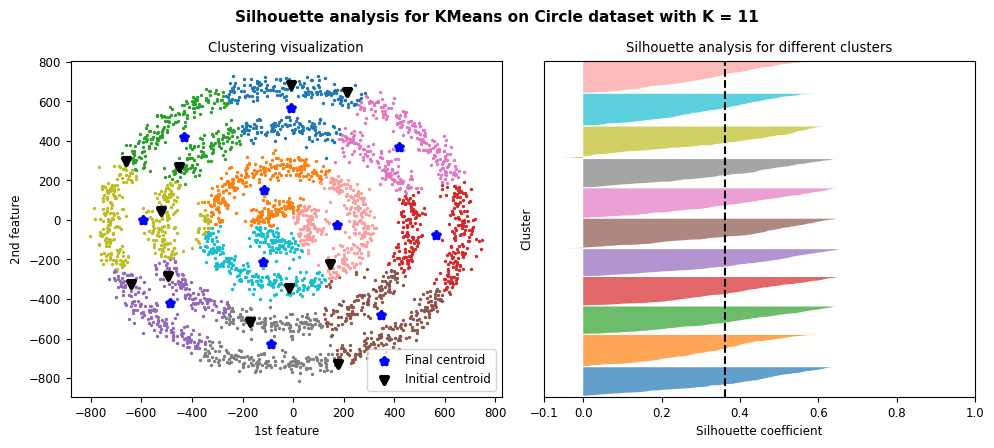

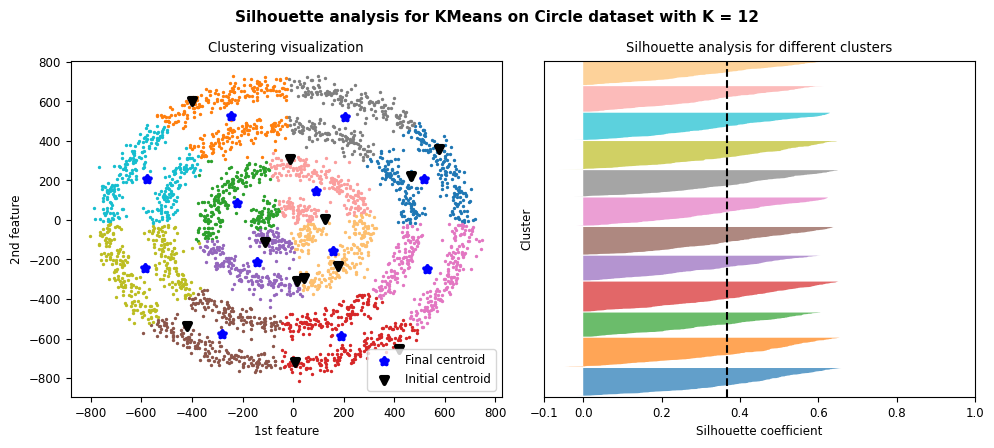

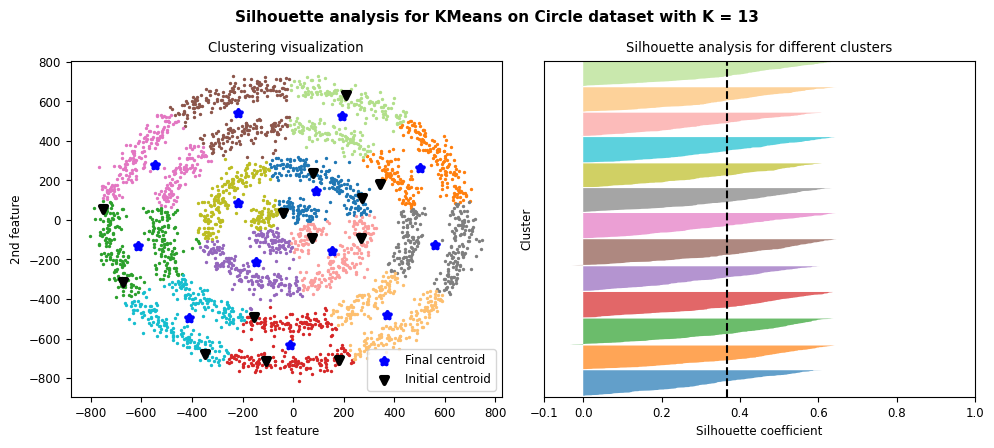

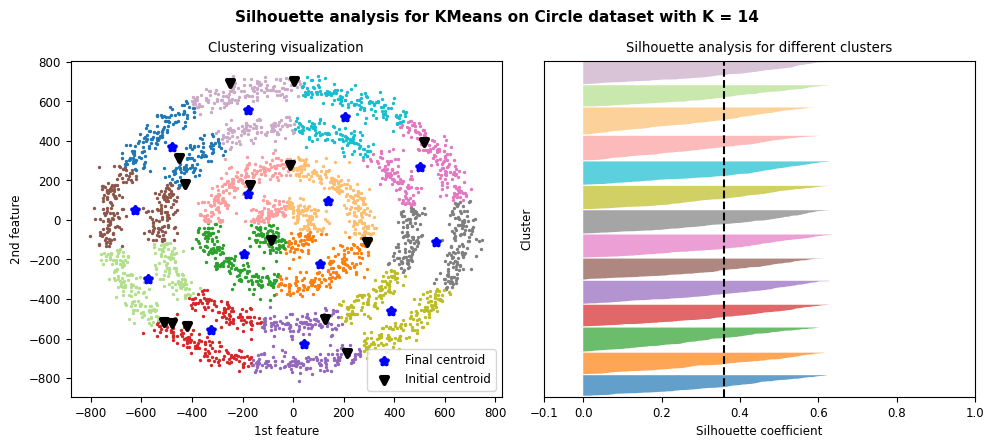

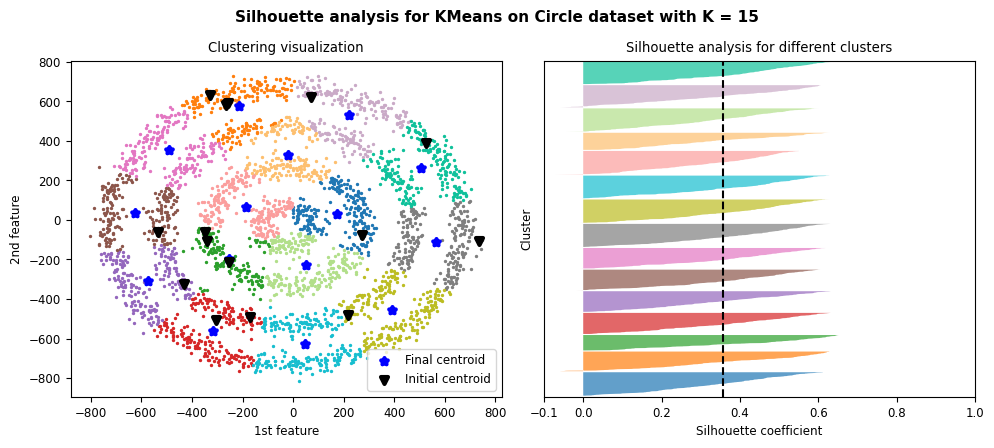

In [271]:
silhouette_scores_manual = []
silhouette_scores_lib = []
distortion_scores = []
times = []
for i in range(1, 16):
    model = KMeans(n_clusters = i, max_iterations=100, cent_init_method='random')
    model.fit(data)
    distortion_scores.append(model.inertia)
    times.append(model.fit_time)
    # Valid values for silhouette_scores are 2 to n_samples - 1 (inclusive)
    if(i > 1):
        silhouette_scores_manual.append(model.silhouette_score())
        silhouette_scores_lib.append(metrics.silhouette_score(data, model.labels, metric='euclidean'))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
        model.plot_results(ax=axs[0])
        model.plot_silhouette(ax=axs[1])
        fig.suptitle(f"Silhouette analysis for KMeans on Circle dataset with K = {i}", fontsize=11, fontweight="bold")
        plt.tight_layout()

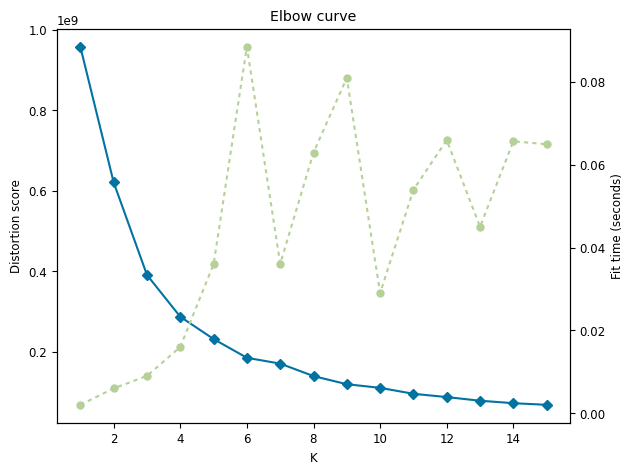

In [272]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax_2 = ax.twinx()
ax_2.plot(x_range, times, color="#B5D197", marker="o", markersize=5, dashes=[2, 2])
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
ax_2.set_ylabel("Fit time (seconds)")
plt.tight_layout()

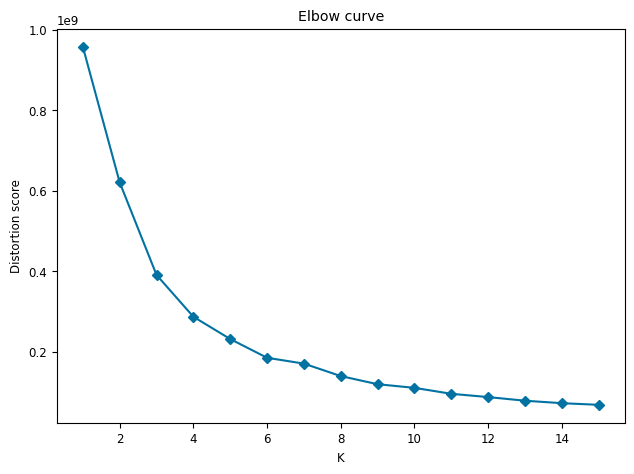

In [273]:
fig, ax = plt.subplots()
x_range = np.arange(1, 16)
ax.plot(x_range, distortion_scores, color="#0272A2", marker="D", markersize=5)
ax.set_title("Elbow curve")
ax.set_xlabel("K")
ax.set_ylabel("Distortion score")
plt.tight_layout()

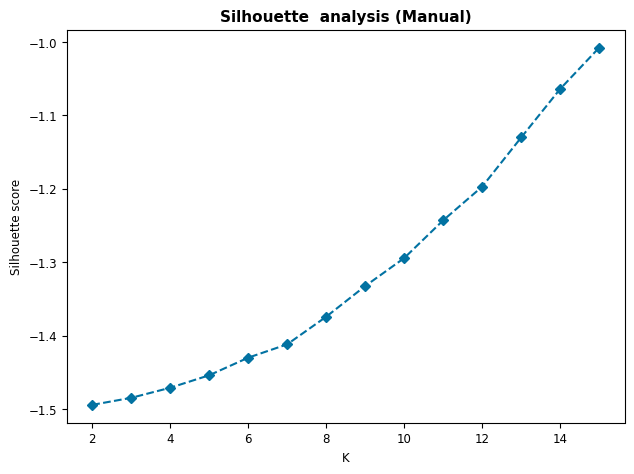

In [274]:
fig, ax = plt.subplots()
x_range = np.arange(2, 16)
ax.plot(x_range, silhouette_scores_manual, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (Manual)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()

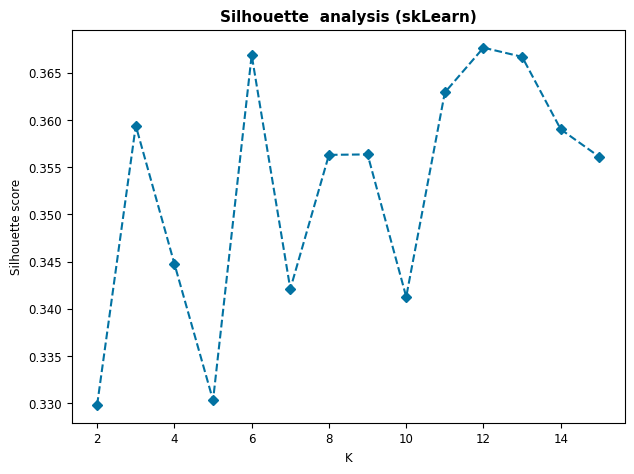

In [275]:
fig, ax = plt.subplots()
ax.plot(x_range, silhouette_scores_lib, color="#0272A2", marker="D", markersize=5, linestyle='--')
ax.set_title("Silhouette  analysis (skLearn)", fontsize=11, fontweight="bold")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
plt.tight_layout()